<a href="https://colab.research.google.com/github/d4vidi4n/borradores/blob/main/Proyecto_IC_Jorge_Estrada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score, classification_report

folder = 'figures'
os.makedirs(folder, exist_ok=True)

# 1) Lectura de datos

In [2]:
from google.colab import files
uploaded = files.upload()  # sensorless_tarea3_train.txt
!ls

Saving df_test_no_labels.csv to df_test_no_labels.csv
Saving df_trainval.csv to df_trainval.csv
df_test_no_labels.csv  df_trainval.csv	figures  sample_data


In [3]:
df_trainval = pd.read_csv('df_trainval.csv')
df_test_no_labels = pd.read_csv('df_test_no_labels.csv')
df_trainval
# df_test_no_labels

,R1_0,R1_1,R1_2,R1_3,R1_4,R1_5,R1_6,R1_7,R1_8,R1_9,...,Humidity_119,Humidity_120,Humidity_121,Humidity_122,Humidity_123,Humidity_124,Humidity_125,Humidity_126,Humidity_127,class
0,12.73430,12.73430,12.73420,12.73420,12.73550,12.73560,12.73700,12.73740,12.73710,12.73700,...,60.0959,60.1002,60.1041,60.1076,60.1108,60.1137,60.1163,60.1187,60.1208,1
1,11.51190,11.52490,11.53670,11.54820,11.55860,11.56800,11.57650,11.58420,11.59120,11.59770,...,64.9539,64.9585,64.9626,64.9663,64.9684,64.9687,64.9689,64.9691,64.9693,1
2,10.85570,10.85860,10.86130,10.86350,10.86440,10.86490,10.86450,10.86390,10.86280,10.86110,...,56.4906,56.4957,56.5004,56.5045,56.5083,56.5118,56.5149,56.5151,56.5149,1
3,12.55170,12.55180,12.55190,12.55190,12.55200,12.55200,12.55210,12.55210,12.55220,12.55220,...,64.5927,64.5912,64.5898,64.5886,64.5875,64.5865,64.5855,64.5847,64.5839,1
4,8.78442,8.77909,8.77488,8.77016,8.76573,8.76157,8.75735,8.75307,8.74919,8.74538,...,58.2097,58.2229,58.2348,58.2456,58.2553,58.2642,58.2722,58.2794,58.2948,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8791,12.39290,12.39290,12.39260,12.39240,12.39260,12.39240,12.39240,12.39290,12.39280,12.39260,...,49.8931,49.8782,49.8613,49.8459,49.8321,49.8195,49.8082,49.7979,49.7878,3
8792,12.83420,12.83410,12.83410,12.83410,12.83410,12.83410,12.83410,12.83410,12.83410,12.83410,...,53.2695,53.2648,53.2605,53.2592,53.2585,53.2578,53.2572,53.2567,53.2562,3
8793,11.99420,11.99420,11.99400,11.99400,11.99380,11.99390,11.99390,11.99350,11.99360,11.99370,...,67.2733,67.2698,67.2665,67.2636,67.3011,67.3350,67.3656,67.3934,67.4185,3
8794,12.94500,12.94540,12.94560,12.94460,12.94370,12.94260,12.94080,12.94000,12.93950,12.93910,...,52.3949,52.3953,52.3956,52.3960,52.3963,52.3965,52.3968,52.3970,52.3989,3


# 2) Gráfico de algunas señales

Puede ser buena idea graficar una cierta cantidad de datos aleatorios que esten cerca, en grupos de la misma clase de esta manera se pueden ver ciertas correlaciones visuales entre las señales y la clase.

El R_6 puede que esté bastante relacionado con la clase ya que se aprecian lineas rectas separadas por la clase, las de clase 1 quedan abajo mientras que las de clase 2 al medio y las otras de clase 3 tienden a quedar arriba. Aunque igual se aprecia cierta confusión entre las clases 2 y 3. Se aprecia claramente en varias señales con varios sensores que las señales de clase 1 quedan abajo.

Analizando la humedad, no se aprecia ni una correlación, lo que sugiere que probablemente esta característica no es representativo del estímulo.

Puede no ser necesario aplicar un filtro ya que algraficar varias señales, se ven lineas rectas apiladas, donde a priori se conclute que el filtrado realmente no ayudaría a distinguir las líneas porque estas ya se distinguen de esta forma.

Vuelvo a reiterar, es probable que las clases 2 y 3 se confundan al momento de clasificar ya que las líneas se tienden a apilar y casi siempre las de clase 1 quedan abajo y las señales de las otras clases otras a veces se superponen.

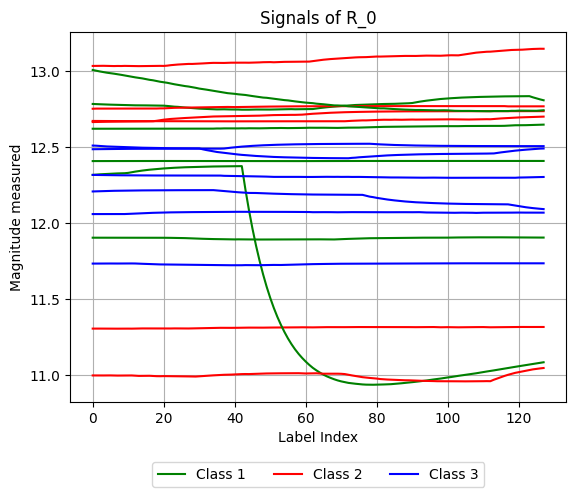

<Figure size 640x480 with 0 Axes>

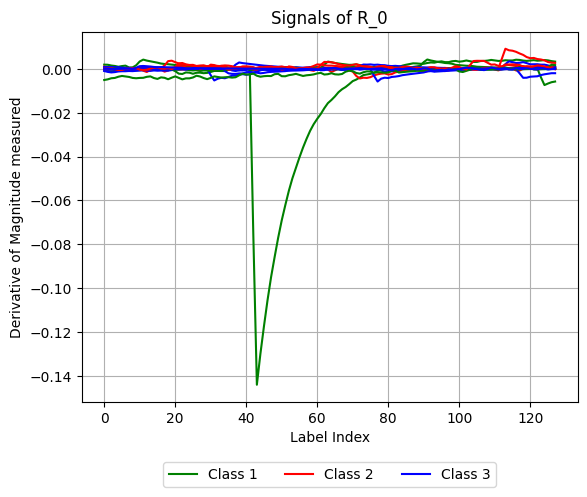

<Figure size 640x480 with 0 Axes>

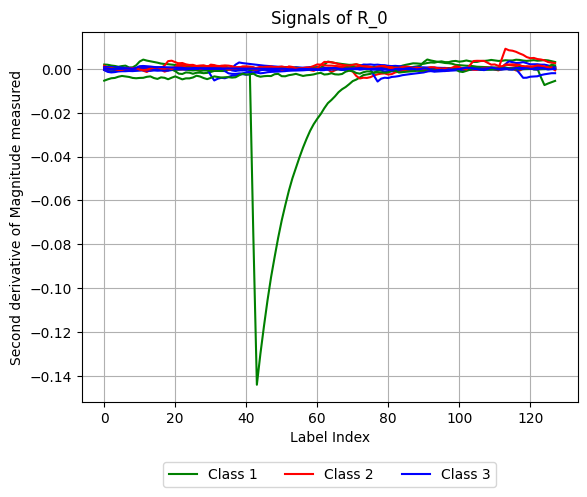

In [39]:
start = 0 #R_start
idx = [start*128, start*128 + 128]
num_sign_per_graph = 6
rs = 20

# Definición única de parámetros gráficos
plot_kwargs_1 = {
    'color': 'green',
    # 'linestyle': '-',
    # 'marker': '',
    'label': 'Class 1'
}

plot_kwargs_2 = {
    'color': 'red',
    # 'linestyle': '--',
    # 'marker': '.',
    'label': 'Class 2'
}

plot_kwargs_3 = {
    'color': 'blue',
    # 'linestyle': '-.',
    # 'marker': 'x',
    'label': 'Class 3'
}

plt.figure()
plt.grid()
plt.xlabel('Label Index')
plt.ylabel('Magnitude measured')
plt.title(f'Signals of R_{start}')

for i in range(num_sign_per_graph):
  plt.plot(np.arange(0,128), df_trainval[df_trainval['class']==1].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]], **plot_kwargs_1)
  plt.plot(np.arange(0,128), df_trainval[df_trainval['class']==2].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]], **plot_kwargs_2)
  plt.plot(np.arange(0,128), df_trainval[df_trainval['class']==3].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]], **plot_kwargs_3)
  if i == 0:
    plt.legend(loc=8, bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.show()

filename = f'signals_R{start}.svg'
filepath = os.path.join(folder, filename)
plt.savefig(filepath)

N_derv = 1
plt.figure()
plt.grid()
plt.xlabel('Label Index')
plt.ylabel('Derivative of Magnitude measured')
plt.title(f'Signals of R_{start}')

for i in range(num_sign_per_graph):
  plt.plot(np.arange(0,128), np.gradient(df_trainval[df_trainval['class']==1].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]],edge_order=N_derv), **plot_kwargs_1)
  plt.plot(np.arange(0,128), np.gradient(df_trainval[df_trainval['class']==2].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]],edge_order=N_derv), **plot_kwargs_2)
  plt.plot(np.arange(0,128), np.gradient(df_trainval[df_trainval['class']==3].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]],edge_order=N_derv), **plot_kwargs_3)
  if i == 0:
    plt.legend(loc=8, bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.show()

filename = f'grad_of_signals_R{start}.svg'
filepath = os.path.join(folder, filename)
plt.savefig(filepath)


N_derv = 2
plt.figure()
plt.grid()
plt.xlabel('Label Index')
plt.ylabel('Second derivative of Magnitude measured')
plt.title(f'Signals of R_{start}')

for i in range(num_sign_per_graph):
  plt.plot(np.arange(0,128), np.gradient(df_trainval[df_trainval['class']==1].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]],edge_order=N_derv), **plot_kwargs_1)
  plt.plot(np.arange(0,128), np.gradient(df_trainval[df_trainval['class']==2].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]],edge_order=N_derv), **plot_kwargs_2)
  plt.plot(np.arange(0,128), np.gradient(df_trainval[df_trainval['class']==3].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]],edge_order=N_derv), **plot_kwargs_3)
  if i == 0:
    plt.legend(loc=8, bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.show()

No se aprecian oscilaciones de ni un tipo, por lo que no se hará un análisis en frecuencia

# 3) Eliminar señales o no

# 4) Filtrado de la señal
No pq no hay ruido ni componentes periodicas que pudieran requerir la extracción de carcaterísticas frecuenciales

# 5) Definición de las características

Vector de cálculo de características (Media, Varianza, etc) ()

In [5]:
from statsmodels.tsa.ar_model import AutoReg

def get_single_ar_coeff(signal, order=3, method='mean'):
    try:
        model = AutoReg(signal, lags=order, old_names=False)
        result = model.fit()
        coeffs = result.params[1:]  # Ignorar el intercepto
        if method == 'mean':
            return np.mean(coeffs)
        elif method == 'norm':
            return np.linalg.norm(coeffs)
        elif method == 'first':
            return coeffs[0]
        elif method == 'max_abs':
            return coeffs[np.argmax(np.abs(coeffs))]
        else:
            return np.nan
    except:
        return np.nan

In [50]:
def extract_features(signal):
  STD_THRESHOLD = 1e-12

  is_constant = np.std(signal) < STD_THRESHOLD
  # is_constant = np.std(signal) == 0
  is_too_short = len(signal) < 2

  return {
      'mean': np.mean(signal),
      'var': np.var(signal),
      'mad': np.median(np.abs(signal - np.median(signal))),
      'max': np.max(signal),
      'min': np.min(signal),
      'ran': np.max(signal) - np.min(signal),
      'sma': np.sum(np.abs(signal)),
      'enrgy': np.sum(signal**2) / len(signal),
      'iqr': sp.iqr(signal),
      'entpy': sp.entropy(signal),
      'arCoeff': get_single_ar_coeff(signal),  # Placeholder; lo puedes reemplazar cuando tengas la función
      'corr': 0.0 if is_constant or is_too_short else np.corrcoef(signal[:-1], signal[1:])[0, 1]
  }

def calculation_feature_vector(df_data):
    sensors = [f'R{j}' for j in range(1, 9)] + ['Humidity']
    feature_list = []

    # for idx, row in df_data[8215:8220].iterrows():
    # for idx, row in df_data[8216:8217].iterrows(): #Dato problemático -> df_data.iloc[8216]
    for idx, row in df_data.iterrows():
        features = {}
        for sensor in sensors:
            start_col = f'{sensor}_0'
            end_col = f'{sensor}_127'
            signal = row[start_col:end_col].to_numpy()
            feats = extract_features(signal)
            # Prefix feature names with sensor ID
            feats_prefixed = {f'{key}_{sensor}': value for key, value in feats.items()}
            features.update(feats_prefixed)
        if 'class' in df_data.columns:
            features['class'] = row['class']
        feature_list.append(features)

    df_features = pd.DataFrame(feature_list)
    return df_features

Hay un caso de un sample que da un valor muy bajo en la varianza, esto genra una división por cero, por esta razón de establecerá una forma de lidiar con este caso y evitar que haya un NaN

#### Cálculo del vector de cracterísticas

In [7]:
train_val_data = calculation_feature_vector(df_trainval)
df_test_data = calculation_feature_vector(df_test_no_labels)

In [84]:
df_train, df_val = train_test_split(train_val_data, test_size=0.3, random_state=10, stratify=train_val_data['class'])
df_test = df_test_data.copy()

In [85]:
# df_test = calculation_feature_vector(df_test_no_labels)
scaler = StandardScaler().fit(df_train.iloc[:,0:-1])

df_train.iloc[:,0:-1] = scaler.transform(df_train.iloc[:,0:-1])
df_val.iloc[:,0:-1] = scaler.transform(df_val.iloc[:,0:-1])
df_test.iloc[:,0:] = scaler.transform(df_test_data.iloc[:,0:])

df_train_w_class = df_train.copy()
df_val_w_class = df_val.copy()

y_train = df_train.pop('class')# - 1
y_val = df_val.pop('class')# - 1

Matriz de confusión de solo las medias, esta idea está sustentada en el hecho de que la mayoría de las señales son líneas rectas o tienen una pendiente muy baja, teniendo esto en cuenta se plantea reducir el vector de carcaterísticas

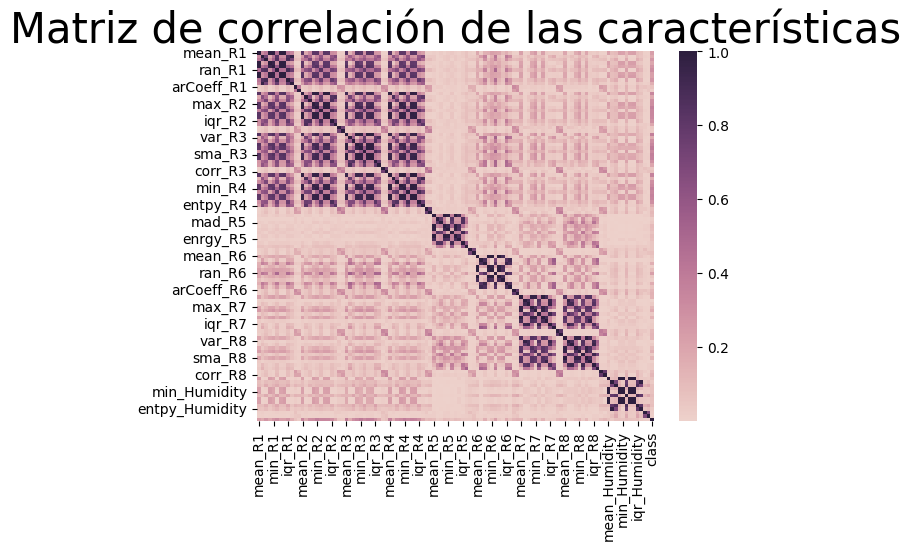

In [87]:
# plt.figure(figsize=(24, 18))
correlation_data = df_train_w_class.corr(method='pearson')
correlation_data_abs_value = abs(df_train_w_class.corr(method='pearson'))
sns.heatmap(correlation_data_abs_value, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title("Matriz de correlación de las características", fontsize=30)
plt.savefig('corr_lineal.svg', format='svg', bbox_inches='tight', pad_inches=0)

Eliminación de señales/características, solo se considera hasta las señales medidas por el sensor R_4 ya que de ahí en adelante la correlación de carcaterísticas comienza a bajar considerablemente

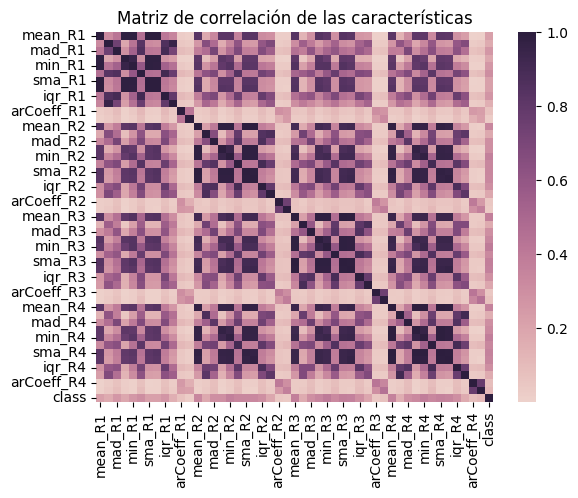

In [89]:
correlation_data_abs_value = abs(df_train.iloc[0:,0:48].assign(**{'class': y_train}).corr(method='pearson'))
sns.heatmap(correlation_data_abs_value, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title("Matriz de correlación de las características")#, fontsize=20)
plt.savefig('corr_lineal.svg', format='svg', bbox_inches='tight', pad_inches=0)

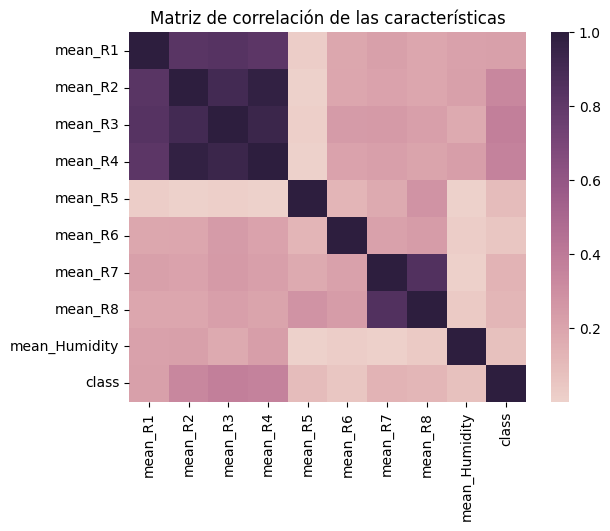

In [90]:
correlation_data_abs_value = abs(df_train[[col for col in df_train.columns if col.startswith('mean_')]].assign(**{'class': y_train}).corr(method='pearson'))
sns.heatmap(correlation_data_abs_value, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title("Matriz de correlación de las características")#, fontsize=20)
plt.savefig('corr_lineal.svg', format='svg', bbox_inches='tight', pad_inches=0)

### Cálculo de un nuevo vector de cracterísticas más intuitivas
Tales como pendiente, derivada, carcaterísticas asociadas a la monotonía de las funciones

In [57]:
def extract_features(signal):
  STD_THRESHOLD = 1e-12

  is_constant = np.std(signal) < STD_THRESHOLD
  # is_constant = np.std(signal) == 0
  is_too_short = len(signal) < 2

  return {
      'mean': np.mean(signal),
      # 'slope': np.polyfit(np.arange(len(signal)), signal, 1)[0], # se considera la pendiente asumiendo que la señal completa es una línea recta, pero puede ser redundante
      'max_grad': max(abs(np.gradient(signal)))
      # 'max_grad': min(np.gradient(signal))
      # 'var': np.var(signal),
      # 'mad': np.median(np.abs(signal - np.median(signal))),
      # 'max': np.max(signal),
      # 'min': np.min(signal),
      # 'ran': np.max(signal) - np.min(signal),
      # 'sma': np.sum(np.abs(signal)),
      # 'enrgy': np.sum(signal**2) / len(signal),
      # 'iqr': sp.iqr(signal),
      # 'entpy': sp.entropy(signal),
      # 'arCoeff': get_single_ar_coeff(signal),  # Placeholder; lo puedes reemplazar cuando tengas la función
      # 'corr': 0.0 if is_constant or is_too_short else np.corrcoef(signal[:-1], signal[1:])[0, 1]
  }

def calculation_feature_vector_II(df_data):
    sensors = [f'R{j}' for j in range(1, 9)] + ['Humidity']
    feature_list = []

    # for idx, row in df_data[8215:8220].iterrows():
    # for idx, row in df_data[8216:8217].iterrows(): #Dato problemático -> df_data.iloc[8216]
    for idx, row in df_data.iterrows():
        features = {}
        for sensor in sensors:
            start_col = f'{sensor}_0'
            end_col = f'{sensor}_127'
            signal = row[start_col:end_col].to_numpy()
            feats = extract_features(signal)
            # Prefix feature names with sensor ID
            feats_prefixed = {f'{key}_{sensor}': value for key, value in feats.items()}
            features.update(feats_prefixed)
        if 'class' in df_data.columns:
            features['class'] = row['class']
        feature_list.append(features)

    df_features = pd.DataFrame(feature_list)
    return df_features

#### Cálculo del vector de cracterísticas

In [58]:
train_val_data_II = calculation_feature_vector_II(df_trainval)
df_test_data_II = calculation_feature_vector_II(df_test_no_labels)

In [70]:
df_train, df_val = train_test_split(train_val_data_II, test_size=0.3, random_state=10, stratify=train_val_data_II['class'])
df_test = df_test_data_II.copy()

In [71]:
# df_test = calculation_feature_vector(df_test_no_labels)
scaler = StandardScaler().fit(df_train.iloc[:,0:-1])

df_train.iloc[:,0:-1] = scaler.transform(df_train.iloc[:,0:-1])
df_val.iloc[:,0:-1] = scaler.transform(df_val.iloc[:,0:-1])
df_test.iloc[:,0:] = scaler.transform(df_test_data_II.iloc[:,0:])

df_train_w_class = df_train.copy()
df_val_w_class = df_val.copy()

y_train = df_train.pop('class')# - 1
y_val = df_val.pop('class')# - 1

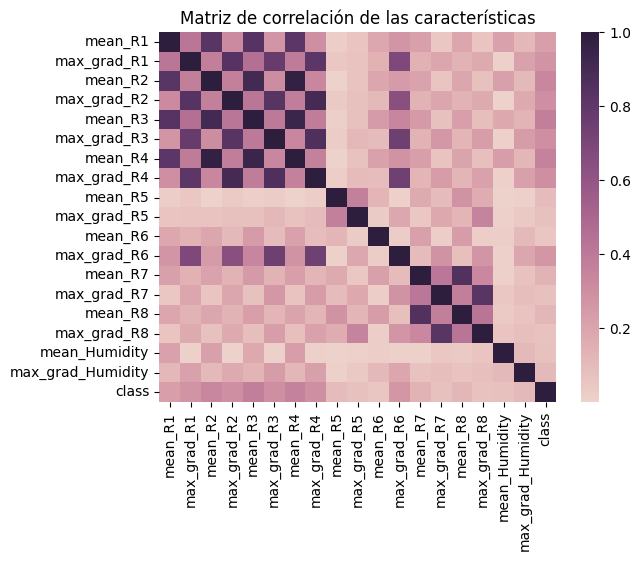

In [78]:
# plt.figure(figsize=(24, 18))
correlation_data = df_train_w_class.corr(method='pearson')
correlation_data_abs_value = abs(df_train_w_class.corr(method='pearson'))
sns.heatmap(correlation_data_abs_value, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title("Matriz de correlación de las características", fontsize=12)
plt.savefig('corr_lineal.svg', format='svg', bbox_inches='tight', pad_inches=0)

# 7) Elección y entrenamiento de un clasificador

Permutación predefinida para la validación del modelo

In [80]:
def predefined_split(class_val):
  n_samples = len(class_val)                                    # Longitud del set de datos de validación, este dato se usará para definir que elementos se usarán para entrenamiento y validación en GridSearchCV()
  n_train_grid_search = int(n_samples * 0.7)                    # 80% de los datos utilizdos para entrenamiento
  n_val_grid_search = n_samples - n_train_grid_search           # El 20% restante para validación

  np.random.seed(42)
  indices = np.random.permutation(n_samples)                    # Tomar índices de forma aleatoria
  test_fold = np.full(n_samples, -1)                            # Se define el arreglo de los índices de elemntos de train y test

  # Asignar 1 a los índices que serán test
  test_indices = indices[:n_val_grid_search]
  test_fold[test_indices] = 1

  ps = PredefinedSplit(test_fold)

  return ps

Permutación predefinida para la validación del modelo

In [116]:
ps = predefined_split(y_val)

In [105]:
import numpy as np
import pandas as pd

# Asegúrate de usar los índices posicionales, no los índices del DataFrame
test_fold = ps.test_fold

# Convertir y_val a un array si es Series con índices no estándar
y_val_array = np.array(y_val)

# Obtener índices posicionales
train_indices = np.where(test_fold == -1)[0]
val_indices = np.where(test_fold == 1)[0]

# Obtener subconjuntos de clases
y_val_train_subset = y_val_array[train_indices]
y_val_val_subset = y_val_array[val_indices]

# Calcular proporciones
train_class_dist = pd.Series(y_val_train_subset).value_counts(normalize=True).sort_index()
val_class_dist = pd.Series(y_val_val_subset).value_counts(normalize=True).sort_index()

# Mostrar proporciones
print("Distribución de clases en el subset de entrenamiento (dentro de validación):")
print(train_class_dist)

print("\nDistribución de clases en el subset de validación (dentro de validación):")
print(val_class_dist)


Distribución de clases en el subset de entrenamiento (dentro de validación):
1.0    0.332972
2.0    0.333514
3.0    0.333514
Name: proportion, dtype: float64

Distribución de clases en el subset de validación (dentro de validación):
1.0    0.333333
2.0    0.333333
3.0    0.333333
Name: proportion, dtype: float64


Función para gejecutar la clasificación dado los hiperparámetros de un SVM y los conjuntos de entrenamiento y validación

In [129]:
def make_clf(svc, params_svc, df_t, y_t, df_v, y_v):

  clf = GridSearchCV(svc, params_svc, cv=ps) #ps es una variable global, no se coloca como entrada para reducir al máximo las entradas de la función y hacer menos confusa las iteraciones

  # GridSearch
  t0 = time.time()
  clf.fit(df_v, y_v)
  t = time.time()
  tiempo_svm_lin_grid_search = t - t0
  print('Tiempo GridSearch SVM lineal: ',tiempo_svm_lin_grid_search)

  display(pd.DataFrame(clf.cv_results_)) # Resultados del GridSearchCV()

  best_clf = clf.best_estimator_ # Se extraen los mejores hiperparámetros calculados a través de GridSearchCV()

  # Entrenamiento del SVM lineal con el conjunto de entrenamiento
  t0 = time.time()
  best_clf.fit(df_t, y_t)
  t = time.time()
  tiempo_svm_lin_training = t - t0
  print('Tiempo entrenamiento SVM lineal: ',tiempo_svm_lin_training)

  print('Tiempo GridSearch + Entrenamiento =',tiempo_svm_lin_grid_search+tiempo_svm_lin_training)

  return best_clf

Función para determinar la matriz de confusión dado un SVM y los conjuntos de validación y predicción de la validación

In [16]:
def conf_mat(bst_clf, y_v, y_pr):
  accu_score = accuracy_score(y_v, y_pr)
  if best_model.kernel == 'poly':
    plt.title(f'C={bst_clf.C}, coef0={bst_clf.coef0}, deg={bst_clf.degree}, gamma={bst_clf.gamma}\nAccuracy = {accu_score:.4f}', fontsize = 10)
    filename = f'mat_conf_kernel-{bst_clf.kernel}_C-{bst_clf.C}_deg-{bst_clf.degree}_gamma-{bst_clf.gamma}.svg'
  else:
    plt.title(f'C={bst_clf.C}, gamma={bst_clf.gamma}\nAccuracy = {accu_score:.4f}', fontsize = 10)
    filename = f'mat_conf_kernel-{bst_clf.kernel}_C-{bst_clf.C}_gamma-{bst_clf.gamma}.svg'

  sns.heatmap(np.round(confusion_matrix(y_v, y_pr, normalize='true'), decimals=6), annot=True, cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=[1, 2, 3],yticklabels=[1, 2, 3])
  plt.suptitle(f'Matriz de confusión normalizada SVM, kernel {bst_clf.kernel}', x=0.43, y=1.00)

  filepath = os.path.join(folder, filename)
  plt.savefig(filepath)

  plt.show()

### GRID SEARCH PARA ENCONTRAR EL MEJOR KERNEL


In [130]:
n_features = df_val.shape[1]
gamma_default = 1 / (n_features * df_val.var().mean())

#### Ejecución del código para encontrar el mejor kernel con el vector de cracaterísticas completo

Tiempo GridSearch SVM lineal:  68.79769968986511


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.289436,0.0,0.072060,0.0,0.01,linear,"{'C': 0.01, 'kernel': 'linear'}",0.670455,0.670455,0.0,9
1,0.357187,0.0,0.094509,0.0,0.01,poly,"{'C': 0.01, 'kernel': 'poly'}",0.368687,0.368687,0.0,20
2,0.451911,0.0,0.196213,0.0,0.01,rbf,"{'C': 0.01, 'kernel': 'rbf'}",0.416667,0.416667,0.0,19
3,0.824675,0.0,0.153394,0.0,0.01,sigmoid,"{'C': 0.01, 'kernel': 'sigmoid'}",0.535354,0.535354,0.0,14
4,0.300215,0.0,0.065715,0.0,0.10,linear,"{'C': 0.1, 'kernel': 'linear'}",0.689394,0.689394,0.0,7
5,0.338776,0.0,0.108897,0.0,0.10,poly,"{'C': 0.1, 'kernel': 'poly'}",0.459596,0.459596,0.0,18
6,0.364192,0.0,0.173397,0.0,0.10,rbf,"{'C': 0.1, 'kernel': 'rbf'}",0.654040,0.654040,0.0,10
7,0.447616,0.0,0.149358,0.0,0.10,sigmoid,"{'C': 0.1, 'kernel': 'sigmoid'}",0.597222,0.597222,0.0,12
8,0.803941,0.0,0.068748,0.0,1.00,linear,"{'C': 1, 'kernel': 'linear'}",0.707071,0.707071,0.0,6
9,0.343488,0.0,0.088447,0.0,1.00,poly,"{'C': 1, 'kernel': 'poly'}",0.574495,0.574495,0.0,13


Tiempo entrenamiento SVM lineal:  3.009989023208618
Tiempo GridSearch + Entrenamiento = 71.80768871307373


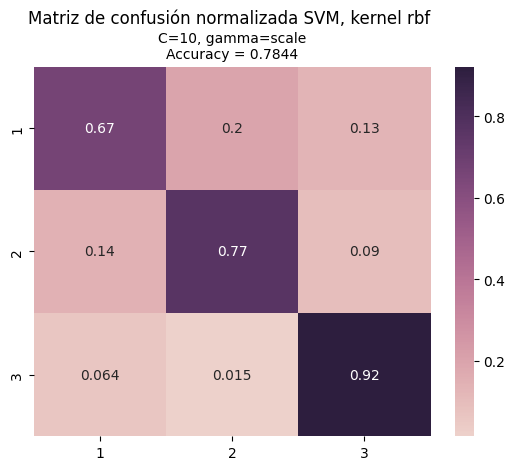

In [ ]:
params = {'C':[0.01, 0.1, 1, 10, 100], 'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
svc = svm.SVC()
best_model = make_clf(svc, params, df_train, y_train, df_val, y_val) # Todas las características

y_pred = best_model.predict(df_val) # Predicción del conjunto de validación

conf_mat(best_model, y_val, y_pred)

#### GRID SEARCH PARA ENCONTRAR EL MEJOR RBF
Al encontrar el mejor kernel, este fue el rbf y debido a que el mejor valor de C fue 100 (máximo valor dado en el Grid Search), se pueban mayores valores de C.


Tiempo GridSearch SVM lineal:  15.358486413955688


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.379913,0.0,0.153608,0.0,1,0.000089,"{'C': 1, 'gamma': 8.857553769927608e-05}",0.544192,0.544192,0.0,25
1,0.342466,0.0,0.139798,0.0,1,0.000886,"{'C': 1, 'gamma': 0.0008857553769927609}",0.660354,0.660354,0.0,18
2,0.281101,0.0,0.128324,0.0,1,0.008858,"{'C': 1, 'gamma': 0.008857553769927608}",0.720960,0.720960,0.0,8
3,0.334365,0.0,0.132195,0.0,1,0.088576,"{'C': 1, 'gamma': 0.08857553769927609}",0.710859,0.710859,0.0,15
4,0.466534,0.0,0.159181,0.0,1,0.885755,"{'C': 1, 'gamma': 0.8857553769927609}",0.583333,0.583333,0.0,24
5,0.316044,0.0,0.138265,0.0,10,0.000089,"{'C': 10, 'gamma': 8.857553769927608e-05}",0.657828,0.657828,0.0,19
6,0.276778,0.0,0.144830,0.0,10,0.000886,"{'C': 10, 'gamma': 0.0008857553769927609}",0.703283,0.703283,0.0,16
7,0.262262,0.0,0.106366,0.0,10,0.008858,"{'C': 10, 'gamma': 0.008857553769927608}",0.741162,0.741162,0.0,3
8,0.398937,0.0,0.130414,0.0,10,0.088576,"{'C': 10, 'gamma': 0.08857553769927609}",0.743687,0.743687,0.0,2
9,0.444132,0.0,0.163270,0.0,10,0.885755,"{'C': 10, 'gamma': 0.8857553769927609}",0.594697,0.594697,0.0,20


Tiempo entrenamiento SVM lineal:  4.375180721282959
Tiempo GridSearch + Entrenamiento = 19.733667135238647


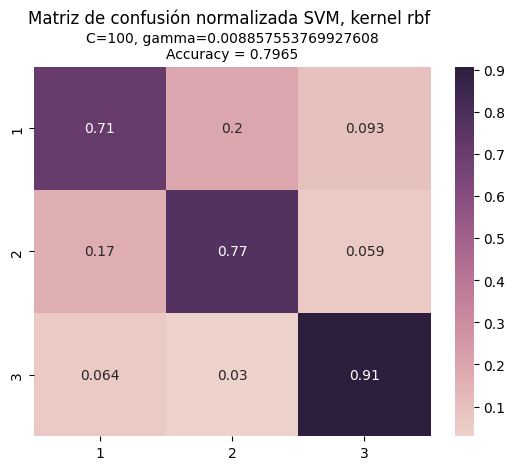

In [109]:
parameters = {'C':[1, 10, 100, 1000, 2000],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
svc = svm.SVC(kernel='rbf')
best_model = make_clf(svc, parameters, df_train, y_train, df_val, y_val)

y_pred = best_model.predict(df_val) # Predicción del conjunto de validación

conf_mat(best_model, y_val, y_pred)

#### GRID SEARCH PARA ENCONTRAR EL MEJOR LINEAL, YA QUE FUE EL 2° MEJOR KERNEL EN EL GRID SEARCH
Aqui el mejor C fue de 10, por lo tanto se establece un rango que incluya este valor y algunos más altos


Tiempo GridSearch SVM lineal:  14.867703199386597


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.785877,0.0,0.063400,0.0,1,{'C': 1},0.707071,0.707071,0.0,3
1,1.130006,0.0,0.058341,0.0,2,{'C': 2},0.707071,0.707071,0.0,3
2,2.265687,0.0,0.093081,0.0,5,{'C': 5},0.719697,0.719697,0.0,1
3,6.099045,0.0,0.060550,0.0,10,{'C': 10},0.718434,0.718434,0.0,2


Tiempo entrenamiento SVM lineal:  24.48259735107422
Tiempo GridSearch + Entrenamiento = 39.350300550460815


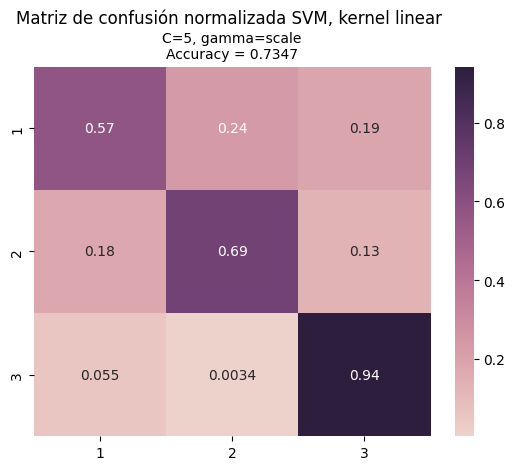

In [ ]:
# parameters = {'C':[1, 10, 100, 1000, 2000]} #Estos valores tan altos hacen que el modelo se tarde demasiado en entrenar
parameters = {'C':[1, 2, 5, 10]}
svc = svm.SVC(kernel='linear')
best_model = make_clf(svc, parameters, df_train, y_train, df_val, y_val)

y_pred = best_model.predict(df_val) # Predicción del conjunto de validación

conf_mat(best_model, y_val, y_pred)

#### GRID SEARCH PARA ENCONTRAR EL MEJOR POLY
Se decidió probar ya que el kernel rbf no dió buenos resultados, no mejoró con respecto al resultado de la búsqueda del mejor grid search


Tiempo GridSearch SVM lineal:  22.03148651123047


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.236584,0.0,0.063698,0.0,1,2,"{'C': 1, 'degree': 2}",0.715909,0.715909,0.0,12
1,0.221122,0.0,0.060820,0.0,1,3,"{'C': 1, 'degree': 3}",0.722222,0.722222,0.0,10
2,0.242301,0.0,0.059966,0.0,1,4,"{'C': 1, 'degree': 4}",0.717172,0.717172,0.0,11
3,0.227802,0.0,0.058372,0.0,1,5,"{'C': 1, 'degree': 5}",0.737374,0.737374,0.0,3
4,0.248653,0.0,0.056121,0.0,10,2,"{'C': 10, 'degree': 2}",0.728535,0.728535,0.0,6
5,0.284022,0.0,0.068022,0.0,10,3,"{'C': 10, 'degree': 3}",0.739899,0.739899,0.0,1
6,0.316657,0.0,0.055446,0.0,10,4,"{'C': 10, 'degree': 4}",0.739899,0.739899,0.0,1
7,0.333171,0.0,0.056473,0.0,10,5,"{'C': 10, 'degree': 5}",0.737374,0.737374,0.0,3
8,0.508646,0.0,0.055762,0.0,100,2,"{'C': 100, 'degree': 2}",0.736111,0.736111,0.0,5
9,0.561954,0.0,0.052308,0.0,100,3,"{'C': 100, 'degree': 3}",0.727273,0.727273,0.0,8


Tiempo entrenamiento SVM lineal:  3.296114683151245
Tiempo GridSearch + Entrenamiento = 25.327601194381714


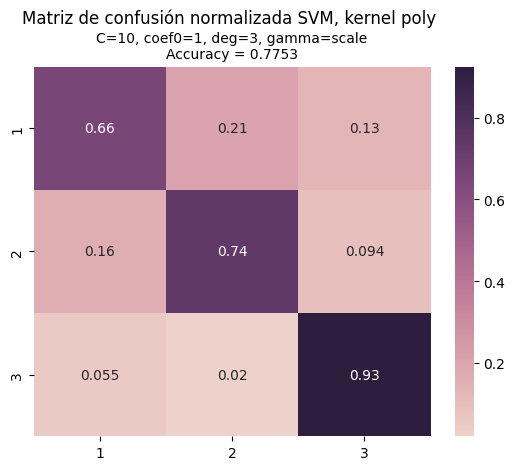

In [110]:
parameters = {'C':[1, 10, 100, 1000, 2000], 'degree':[2,3,4,5]}
svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')
best_model = make_clf(svc, parameters, df_train, y_train, df_val, y_val)

y_pred = best_model.predict(df_val) # Predicción del conjunto de validación

conf_mat(best_model, y_val, y_pred)

### Reducción de carcaterísticas prelimnar, solo el vector con las medias de las señales medidas
Idea sustentada en la forma de las señales

#### EL MEJOR RESULTADO EN TEST
REDUCCIÓN DEL VECTOR DE CARACTERÍSTICAS (SOLO LAS MEDIAS) Y NUEVO POLY

In [133]:
n_features = df_val.shape[1]
gamma_default = 1 / (n_features * df_val[[col for col in df_val.columns if col.startswith('mean_')]].var().mean())

Tiempo GridSearch SVM lineal:  108.82047080993652


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.106019,0.0,0.031481,0.0,1,2,"{'C': 1, 'degree': 2}",0.731061,0.731061,0.0,20
1,0.121948,0.0,0.027043,0.0,1,3,"{'C': 1, 'degree': 3}",0.770202,0.770202,0.0,19
2,0.166652,0.0,0.026159,0.0,1,4,"{'C': 1, 'degree': 4}",0.777778,0.777778,0.0,17
3,0.201501,0.0,0.024820,0.0,1,5,"{'C': 1, 'degree': 5}",0.795455,0.795455,0.0,13
4,0.180797,0.0,0.027678,0.0,10,2,"{'C': 10, 'degree': 2}",0.775253,0.775253,0.0,18
5,0.228273,0.0,0.024348,0.0,10,3,"{'C': 10, 'degree': 3}",0.797980,0.797980,0.0,12
6,0.390989,0.0,0.026009,0.0,10,4,"{'C': 10, 'degree': 4}",0.819444,0.819444,0.0,10
7,0.368176,0.0,0.019415,0.0,10,5,"{'C': 10, 'degree': 5}",0.819444,0.819444,0.0,10
8,0.689931,0.0,0.024523,0.0,100,2,"{'C': 100, 'degree': 2}",0.782828,0.782828,0.0,16
9,1.298856,0.0,0.021964,0.0,100,3,"{'C': 100, 'degree': 3}",0.823232,0.823232,0.0,9


Tiempo entrenamiento SVM lineal:  33.341949462890625
Tiempo GridSearch + Entrenamiento = 142.16242027282715


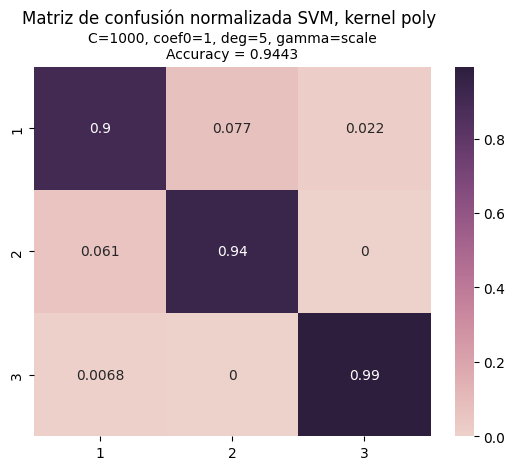

In [134]:
# parameters = {'C':[200, 500, 1000, 2000], 'degree':[2,3,4,5]} # C PROBADOS DE FORMA EMPÍRICA
parameters = {'C':[1, 10, 100, 1000, 2000], 'degree':[2,3,4,5]} #MISMOS c PROBADOS EN LA BÚSQUEDA DEL MEJOR POLY
svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')
best_model = make_clf(svc, parameters, df_train[[col for col in df_train.columns if col.startswith('mean_')]], y_train, df_val[[col for col in df_val.columns if col.startswith('mean_')]], y_val) # Solo las medias de las mediciones de cada sensor (EMPÍRICO)

y_pred = best_model.predict(df_val[[col for col in df_val.columns if col.startswith('mean_')]]) # Predicción del conjunto de validación

conf_mat(best_model, y_val, y_pred)

#### Y si probamos con el vector de características reducido pero esta vez con un RBF? ESTE SI ES EL MEJOR EN TEST

Tiempo GridSearch SVM lineal:  6.776724815368652


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.173126,0.0,0.084828,0.0,1,0.000106,"{'C': 1, 'gamma': 0.00010569882210926341}",0.309343,0.309343,0.0,25
1,0.186485,0.0,0.083148,0.0,1,0.001057,"{'C': 1, 'gamma': 0.0010569882210926342}",0.569444,0.569444,0.0,23
2,0.144305,0.0,0.069626,0.0,1,0.010570,"{'C': 1, 'gamma': 0.010569882210926342}",0.652778,0.652778,0.0,20
3,0.109185,0.0,0.057040,0.0,1,0.105699,"{'C': 1, 'gamma': 0.10569882210926342}",0.744949,0.744949,0.0,13
4,0.109092,0.0,0.052668,0.0,1,1.056988,"{'C': 1, 'gamma': 1.0569882210926342}",0.852273,0.852273,0.0,7
5,0.164983,0.0,0.081635,0.0,10,0.000106,"{'C': 10, 'gamma': 0.00010569882210926341}",0.564394,0.564394,0.0,24
6,0.171483,0.0,0.072071,0.0,10,0.001057,"{'C': 10, 'gamma': 0.0010569882210926342}",0.651515,0.651515,0.0,21
7,0.128658,0.0,0.058304,0.0,10,0.010570,"{'C': 10, 'gamma': 0.010569882210926342}",0.713384,0.713384,0.0,16
8,0.111032,0.0,0.047354,0.0,10,0.105699,"{'C': 10, 'gamma': 0.10569882210926342}",0.792929,0.792929,0.0,10
9,0.105403,0.0,0.042192,0.0,10,1.056988,"{'C': 10, 'gamma': 1.0569882210926342}",0.915404,0.915404,0.0,4


Tiempo entrenamiento SVM lineal:  0.8932003974914551
Tiempo GridSearch + Entrenamiento = 7.669925212860107


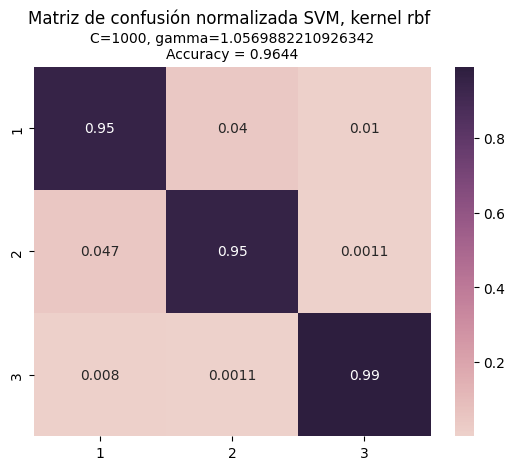

In [135]:
parameters = {'C':[1, 10, 100, 1000, 2000],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
svc = svm.SVC(kernel='rbf')
best_model = make_clf(svc, parameters, df_train[[col for col in df_train.columns if col.startswith('mean_')]], y_train, df_val[[col for col in df_val.columns if col.startswith('mean_')]], y_val) # Solo las medias de las mediciones de cada sensor (EMPÍRICO)

y_pred = best_model.predict(df_val[[col for col in df_val.columns if col.startswith('mean_')]]) # Predicción del conjunto de validación

conf_mat(best_model, y_val, y_pred)

El anterior resultó ser el mejor resultado en test, con un accuracy en test de 0.96!!!!!

#### Ahora si probamos con el kernel lineal de nuevo??

Tiempo GridSearch SVM lineal:  2.2504067420959473


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.164466,0.0,0.034486,0.0,1,{'C': 1},0.633838,0.633838,0.0,4
1,0.235384,0.0,0.032734,0.0,2,{'C': 2},0.637626,0.637626,0.0,3
2,0.317515,0.0,0.033018,0.0,5,{'C': 5},0.641414,0.641414,0.0,1
3,0.485286,0.0,0.040200,0.0,10,{'C': 10},0.640152,0.640152,0.0,2


Tiempo entrenamiento SVM lineal:  7.989392042160034
Tiempo GridSearch + Entrenamiento = 10.239798784255981


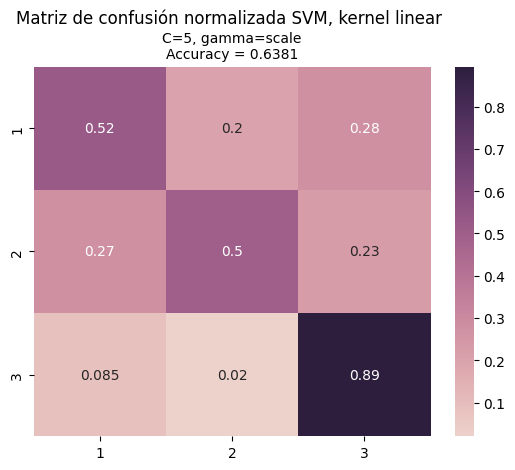

In [ ]:
parameters = {'C':[1, 2, 5, 10]}
svc = svm.SVC(kernel='linear')
best_model = make_clf(svc, parameters, df_train[[col for col in df_train.columns if col.startswith('mean_')]], y_train, df_val[[col for col in df_val.columns if col.startswith('mean_')]], y_val)

y_pred = best_model.predict(df_val[[col for col in df_val.columns if col.startswith('mean_')]]) # Predicción del conjunto de validación

conf_mat(best_model, y_val, y_pred)

### Selección de cracterísticas

#### Reducción de carcaterísticas mediante SelectKBest
De esta forma sofisticamos un poco la reducción de características, de esta manera se puede optimizar el resultado del accuracy en función de las características

Este conjunto tiene las 12 características de las señales captadas por los sensores R_1, R_2, R_3, R_4, esto está basado en ele hecho de que ne esa zona de la matriz de confusión hay un color más oscuro, por la escala de colores esto significa una mayor correlación con la clase

In [127]:
# selector = SelectKBest(score_func=f_classif, k=18).fit(df_train, y_train)
selector = SelectKBest(score_func=f_classif, k=42).fit(df_train, y_train)

best_indx_filter = np.where(selector.get_support())[0]
best_feat_filter = [df_train.keys()[i] for i in np.where(selector.get_support())[0]] #Toma los indices de aquellas características que fueron seleccionadas como importantes con el método y luego busca el nombre de la característica correspodiente en la lista original de nombres definida al inicio del código

print('Mejores características:', best_feat_filter)

# # Se define el nuevo conjunto de entrenamiento y validación tomando las características más importantes encontradas con este método
df_train_filter = df_train.iloc[:, best_indx_filter]
df_val_filter = df_val.iloc[:, best_indx_filter]
df_test_filter = df_test.iloc[:, best_indx_filter]

Mejores características: ['mean_R1', 'var_R1', 'mad_R1', 'min_R1', 'ran_R1', 'sma_R1', 'enrgy_R1', 'iqr_R1', 'mean_R2', 'var_R2', 'mad_R2', 'max_R2', 'min_R2', 'ran_R2', 'sma_R2', 'enrgy_R2', 'iqr_R2', 'entpy_R2', 'mean_R3', 'mad_R3', 'max_R3', 'min_R3', 'ran_R3', 'sma_R3', 'enrgy_R3', 'iqr_R3', 'entpy_R3', 'mean_R4', 'mad_R4', 'max_R4', 'min_R4', 'ran_R4', 'sma_R4', 'enrgy_R4', 'iqr_R4', 'entpy_R4', 'mean_R6', 'max_R6', 'min_R6', 'ran_R6', 'sma_R6', 'ran_Humidity']


Tiempo GridSearch SVM lineal:  12.654967069625854


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.384573,0.0,0.219908,0.0,1,0.000089,"{'C': 1, 'gamma': 8.857553769927608e-05}",0.513889,0.513889,0.0,25
1,0.242927,0.0,0.147841,0.0,1,0.000886,"{'C': 1, 'gamma': 0.0008857553769927609}",0.631313,0.631313,0.0,23
2,0.164634,0.0,0.081221,0.0,1,0.008858,"{'C': 1, 'gamma': 0.008857553769927608}",0.675505,0.675505,0.0,18
3,0.151079,0.0,0.098308,0.0,1,0.088576,"{'C': 1, 'gamma': 0.08857553769927609}",0.734848,0.734848,0.0,12
4,0.272043,0.0,0.155596,0.0,1,0.885755,"{'C': 1, 'gamma': 0.8857553769927609}",0.782828,0.782828,0.0,7
5,0.341445,0.0,0.184631,0.0,10,0.000089,"{'C': 10, 'gamma': 8.857553769927608e-05}",0.621212,0.621212,0.0,24
6,0.305986,0.0,0.158942,0.0,10,0.000886,"{'C': 10, 'gamma': 0.0008857553769927609}",0.656566,0.656566,0.0,21
7,0.251335,0.0,0.133980,0.0,10,0.008858,"{'C': 10, 'gamma': 0.008857553769927608}",0.710859,0.710859,0.0,16
8,0.264456,0.0,0.141609,0.0,10,0.088576,"{'C': 10, 'gamma': 0.08857553769927609}",0.765152,0.765152,0.0,9
9,0.363940,0.0,0.147321,0.0,10,0.885755,"{'C': 10, 'gamma': 0.8857553769927609}",0.803030,0.803030,0.0,1


Tiempo entrenamiento SVM lineal:  2.3538870811462402
Tiempo GridSearch + Entrenamiento = 15.008854150772095


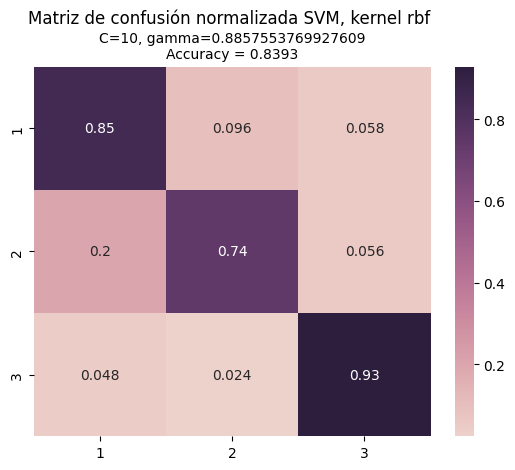

In [128]:
parameters = {'C':[1, 10, 100, 1000, 2000],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
svc = svm.SVC(kernel='rbf')

# parameters = {'C':[1, 10, 100, 1000, 2000], 'degree':[2,3,4,5]} #MISMOS c PROBADOS EN LA BÚSQUEDA DEL MEJOR POLY
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

best_model = make_clf(svc, parameters, df_train_filter, y_train, df_val_filter, y_val)

y_pred_filter = best_model.predict(df_val_filter)

conf_mat(best_model, y_val, y_pred_filter)

Hasta el momento lo mejor es con 40 carcaterísticas

#### Selección de características mediante *wrapper strategy*

In [ ]:
# Asegúrate de que el SVC sea lineal
svc = svm.SVC(kernel='linear', C=10)
svc.fit(df_train, y_train)

selector = SelectFromModel(estimator=svc, prefit=True, threshold='mean', importance_getter='coef_')
best_indx_wrapper = np.where(selector.get_support())[0]
best_feat_wrapper = [df_train.keys()[i] for i in np.where(selector.get_support())[0]] #Toma los indices de aquellas características que fueron seleccionadas como importantes con el método y luego busca el nombre de la característica correspodiente en la lista original de nombres definida al inicio del código

print('Mejores características:',best_feat_wrapper)
# Se define el nuevo conjunto de entrenamiento y validación tomando las características más importantes encontradas con este método
df_train_wrapper = df_train.iloc[:, best_indx_filter]
df_val_wrapper = df_val.iloc[:, best_indx_filter]
df_test_wrapper = df_test.iloc[:, best_indx_filter]

Mejores características: ['mean_R1', 'var_R1', 'sma_R1', 'enrgy_R1', 'entpy_R1', 'mean_R2', 'sma_R2', 'enrgy_R2', 'iqr_R2', 'entpy_R2', 'mean_R3', 'sma_R3', 'enrgy_R3', 'entpy_R3', 'mean_R4', 'max_R4', 'sma_R4', 'enrgy_R4', 'mean_R6', 'mad_R6', 'max_R6', 'min_R6', 'sma_R6', 'enrgy_R6', 'var_R7', 'mad_R7', 'enrgy_R7', 'iqr_R7', 'var_R8', 'enrgy_R8', 'enrgy_Humidity']


In [ ]:
parameters = {'C':[1, 10, 100, 1000, 2000],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
svc = svm.SVC(kernel='rbf')

# parameters = {'C':[1, 10, 100, 1000, 2000], 'degree':[2,3,4,5]} #MISMOS c PROBADOS EN LA BÚSQUEDA DEL MEJOR POLY
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

best_model = make_clf(svc, parameters, df_train_wrapper, y_train, df_val_wrapper, y_val)

y_pred_wrapper = best_model.predict(df_val_wrapper)

conf_mat(best_model, y_val, y_pred_wrapper)

#### Selección de carcaterísticas mediante PCA

In [24]:
pca = PCA(n_components=48)
pca.fit(df_train)

df_train_pca = pd.DataFrame(pca.transform(df_train))
df_val_pca = pd.DataFrame(pca.transform(df_val))
df_test_pca = pd.DataFrame(pca.transform(df_test))

Tiempo GridSearch SVM lineal:  10.86939001083374


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.214685,0.0,0.098464,0.0,1,0.000089,"{'C': 1, 'gamma': 8.857553769927608e-05}",0.537879,0.537879,0.0,25
1,0.175955,0.0,0.095456,0.0,1,0.000886,"{'C': 1, 'gamma': 0.0008857553769927609}",0.651515,0.651515,0.0,19
2,0.151742,0.0,0.080286,0.0,1,0.008858,"{'C': 1, 'gamma': 0.008857553769927608}",0.713384,0.713384,0.0,8
3,0.215651,0.0,0.090387,0.0,1,0.088576,"{'C': 1, 'gamma': 0.08857553769927609}",0.707071,0.707071,0.0,10
4,0.274147,0.0,0.110963,0.0,1,0.885755,"{'C': 1, 'gamma': 0.8857553769927609}",0.594697,0.594697,0.0,24
5,0.172443,0.0,0.089812,0.0,10,0.000089,"{'C': 10, 'gamma': 8.857553769927608e-05}",0.654040,0.654040,0.0,18
6,0.169813,0.0,0.080518,0.0,10,0.000886,"{'C': 10, 'gamma': 0.0008857553769927609}",0.691919,0.691919,0.0,16
7,0.151428,0.0,0.070580,0.0,10,0.008858,"{'C': 10, 'gamma': 0.008857553769927608}",0.734848,0.734848,0.0,2
8,0.251632,0.0,0.088178,0.0,10,0.088576,"{'C': 10, 'gamma': 0.08857553769927609}",0.717172,0.717172,0.0,7
9,0.257256,0.0,0.110348,0.0,10,0.885755,"{'C': 10, 'gamma': 0.8857553769927609}",0.601010,0.601010,0.0,20


Tiempo entrenamiento SVM lineal:  2.785944700241089
Tiempo GridSearch + Entrenamiento = 13.655334711074829


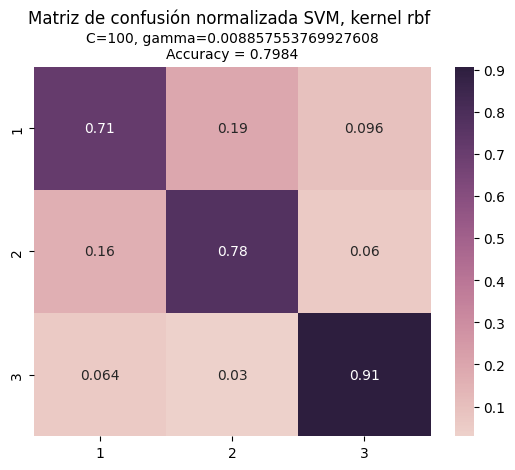

In [25]:
parameters = {'C':[1, 10, 100, 1000, 2000],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
svc = svm.SVC(kernel='rbf')

# parameters = {'C':[1, 10, 100, 1000, 2000], 'degree':[2,3,4,5]} #MISMOS c PROBADOS EN LA BÚSQUEDA DEL MEJOR POLY
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

best_model = make_clf(svc, parameters, df_train_pca, y_train, df_val_pca, y_val)

y_pred_pca = best_model.predict(df_val_pca)

conf_mat(best_model, y_val, y_pred_pca)

#### Selección de carcaterísticas, máxima derivada y media

Tiempo GridSearch SVM lineal:  11.11550784111023


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.383623,0.0,0.152590,0.0,1,0.000089,"{'C': 1, 'gamma': 8.857553769927608e-05}",0.344697,0.344697,0.0,25
1,0.294263,0.0,0.099699,0.0,1,0.000886,"{'C': 1, 'gamma': 0.0008857553769927609}",0.575758,0.575758,0.0,23
2,0.178121,0.0,0.124298,0.0,1,0.008858,"{'C': 1, 'gamma': 0.008857553769927608}",0.675505,0.675505,0.0,18
3,0.216356,0.0,0.134013,0.0,1,0.088576,"{'C': 1, 'gamma': 0.08857553769927609}",0.747475,0.747475,0.0,13
4,0.335997,0.0,0.169106,0.0,1,0.885755,"{'C': 1, 'gamma': 0.8857553769927609}",0.800505,0.800505,0.0,8
5,0.591608,0.0,0.315153,0.0,10,0.000089,"{'C': 10, 'gamma': 8.857553769927608e-05}",0.568182,0.568182,0.0,24
6,0.541055,0.0,0.251968,0.0,10,0.000886,"{'C': 10, 'gamma': 0.0008857553769927609}",0.656566,0.656566,0.0,21
7,0.287966,0.0,0.210796,0.0,10,0.008858,"{'C': 10, 'gamma': 0.008857553769927608}",0.727273,0.727273,0.0,16
8,0.338614,0.0,0.141643,0.0,10,0.088576,"{'C': 10, 'gamma': 0.08857553769927609}",0.797980,0.797980,0.0,9
9,0.591719,0.0,0.102491,0.0,10,0.885755,"{'C': 10, 'gamma': 0.8857553769927609}",0.853535,0.853535,0.0,2


Tiempo entrenamiento SVM lineal:  1.4055023193359375
Tiempo GridSearch + Entrenamiento = 12.521010160446167


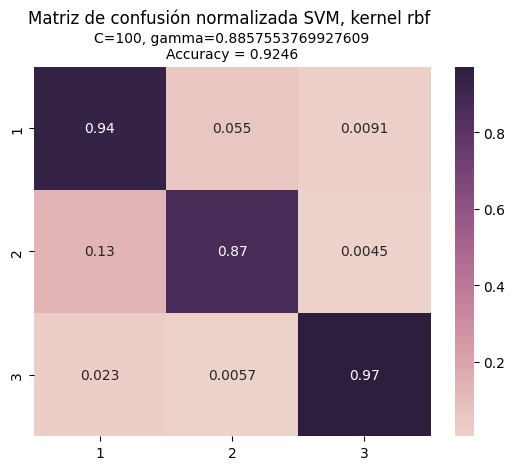

In [74]:
parameters = {'C':[1, 10, 100, 1000, 2000],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
svc = svm.SVC(kernel='rbf')
best_model = make_clf(svc, parameters, df_train, y_train, df_val, y_val)

y_pred = best_model.predict(df_val) # Predicción del conjunto de validación

conf_mat(best_model, y_val, y_pred)

Tiempo GridSearch SVM lineal:  53.89662742614746


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.110575,0.0,0.028038,0.0,1,2,"{'C': 1, 'degree': 2}",0.729798,0.729798,0.0,20
1,0.118390,0.0,0.026894,0.0,1,3,"{'C': 1, 'degree': 3}",0.742424,0.742424,0.0,19
2,0.147812,0.0,0.027451,0.0,1,4,"{'C': 1, 'degree': 4}",0.758838,0.758838,0.0,17
3,0.132417,0.0,0.025552,0.0,1,5,"{'C': 1, 'degree': 5}",0.771465,0.771465,0.0,16
4,0.165810,0.0,0.028111,0.0,10,2,"{'C': 10, 'degree': 2}",0.747475,0.747475,0.0,18
5,0.176609,0.0,0.024604,0.0,10,3,"{'C': 10, 'degree': 3}",0.786616,0.786616,0.0,12
6,0.228768,0.0,0.025950,0.0,10,4,"{'C': 10, 'degree': 4}",0.795455,0.795455,0.0,11
7,0.294776,0.0,0.023122,0.0,10,5,"{'C': 10, 'degree': 5}",0.796717,0.796717,0.0,10
8,0.608857,0.0,0.023639,0.0,100,2,"{'C': 100, 'degree': 2}",0.775253,0.775253,0.0,15
9,0.648836,0.0,0.021264,0.0,100,3,"{'C': 100, 'degree': 3}",0.800505,0.800505,0.0,7


Tiempo entrenamiento SVM lineal:  47.35198616981506
Tiempo GridSearch + Entrenamiento = 101.24861359596252


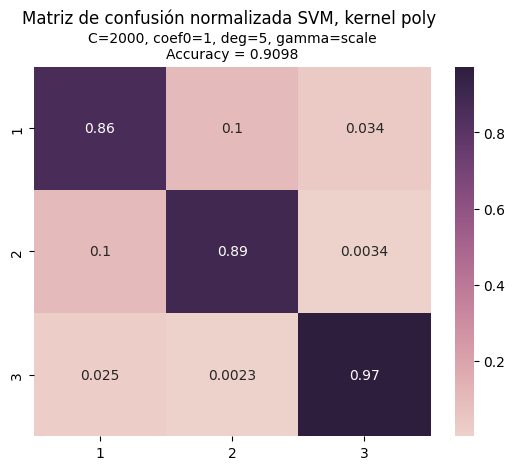

In [76]:
parameters = {'C':[1, 10, 100, 1000, 2000], 'degree':[2,3,4,5]}
svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')
best_model = make_clf(svc, parameters, df_train, y_train, df_val, y_val)

y_pred = best_model.predict(df_val) # Predicción del conjunto de validación

conf_mat(best_model, y_val, y_pred)

No mejora con respecto al vector de cracterísticas que solo tiene las medias

# Predicción del conjunto de test

In [113]:
best_model

SVC(C=100, gamma=np.float64(0.8857553769927609))

In [115]:
# y_pred_test = best_model.predict(df_test)
y_pred_test = best_model.predict(df_test[[col for col in df_test.columns if col.startswith('mean_')]])

with open('pred_test.csv', 'w') as f:
  f.write('Id,Category\n')
  for i in range(len(df_test)):
    f.write(f'{df_test.index[i]},{int(y_pred_test[i])}\n')

# II) Nuevo vector de características
Se prueba un nuevo vector de características, esta vez incluyendo características tales como el mínimo, el máximo y la media móvil, entre otras.

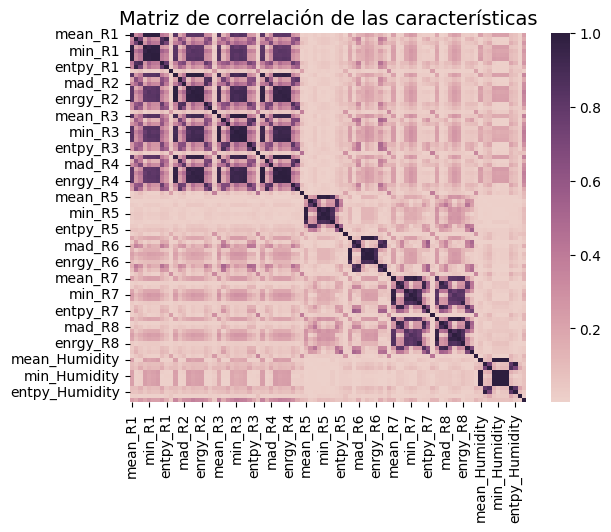

In [ ]:
# correlation_data = df_train_w_class[df_train_w_class['class']==3].corr(method='pearson')
# correlation_data_abs_value = abs(df_train_w_class[df_train_w_class['class']==3].corr(method='pearson'))

correlation_data = df_train_w_class.corr(method='pearson')
correlation_data_abs_value = abs(df_train_w_class.corr(method='pearson'))
sns.heatmap(correlation_data_abs_value, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title("Matriz de correlación de las características", fontsize=14)
plt.savefig('corr_lineal.svg', format='svg', bbox_inches='tight', pad_inches=0)

Se concluye que la media es lo que hace una clasificación relativamente exitosa (50% de corr con la clase), pero la varianza no ayuda en nada (por debajo de 30% de corr con la clase para las primeras 4 características y caso 0% para el resto). Así que se calcula un nuevo vector de carcaterísticas. Finalmente lo dejé solo con la media y el mismo clasificador que usé al inicio con el 1er vector de carcaterísticas que usé (media y varianza). Ahora lo que queda pendiente es usar otras características para justificar que la media es la mejor.

In [ ]:
def calculation_feature_vector_2(df_data):

  caracs_list = []

  big_data_arr = np.zeros((len(df_data), 18))

  for i in range(0, len(df_data)):
  # for i in range(0, 2):
    data_list = []

    for j in range(1,10):

      if j == 9:
        df_calc = df_data.loc[i, f'Humidity_0':f'Humidity_127'] #display(df_trainval.loc[i, f'Humidity_0':f'Humidity_127'])
      else:
        df_calc = df_data.loc[i, f'R{j}_0':f'R{j}_127'] #display(df_trainval.loc[i, f'R{j}_0':f'R{j}_127'])

      if i == 0:
        # 2° it features
        caracs_list.append('mean_' + str(j))
        # caracs_list.append('var_' + str(j))
        # caracs_list.append('min_' + str(j))
        # caracs_list.append('max_' + str(j))
        # caracs_list.append('sma_' + str(j))
        caracs_list.append('slope_' + str(j))

        df = pd.DataFrame(columns=caracs_list)

      data_list.append(np.mean(df_calc))
      # data_list.append(np.var(df_calc))
      # data_list.append(min(df_calc))
      # data_list.append(max(df_calc))
      # data_list.append(np.ma.average(df_calc))
      # 'slope': np.polyfit(x, signal, 1)[0]
      data_list.append(np.polyfit(np.arange(128), df_calc, 1)[0]) #Nueva carcaterística, probada hoy (08/07) al final del día

    # print(i)
    big_data_arr[i,:] = np.array(data_list)

  df = pd.DataFrame(big_data_arr, columns=caracs_list)

  if 'class' in df_data.columns:
    df = pd.concat([df, df_data['class']], axis=1)

  return df

In [ ]:
train_val_data_II = calculation_feature_vector_2(df_trainval)
df_test = calculation_feature_vector_2(df_test_no_labels)

In [ ]:
df_train, df_val = train_test_split(train_val_data_II, test_size=0.3, random_state=10, stratify=train_val_data_II['class'])

scaler = StandardScaler().fit(df_train.iloc[:,0:18])

df_train.iloc[:,0:18] = scaler.transform(df_train.iloc[:,0:18])
df_val.iloc[:,0:18] = scaler.transform(df_val.iloc[:,0:18])
df_test.iloc[:,0:18] = scaler.transform(df_test.iloc[:,0:18])

df_train_w_class = df_train.copy()
df_val_w_class = df_val.copy()

y_train = df_train.pop('class')# - 1
y_val = df_val.pop('class')# - 1

In [ ]:
# 1° iteración:
# parameters = {'C':[0.01, 0.1, 1, 10, 100]}
# svc = svm.SVC(kernel='linear')

# 2° iteración:
# parameters = {'C':[0.1, 1, 10], 'degree':[2,3,4]}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

# 3° iteración:
parameters = {'C':[200, 500, 1000, 5000], 'degree':[2,3,4]}
svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

clf = GridSearchCV(svc, parameters, cv=ps)

# GridSearch
t0 = time.time()
clf.fit(df_val, y_val)
t = time.time()
tiempo_svm_lin_grid_search = t - t0
print('Tiempo GridSearch SVM lineal: ',tiempo_svm_lin_grid_search)

display(pd.DataFrame(clf.cv_results_)) # Resultados del GridSearchCV()

best_model = clf.best_estimator_ # Se extraen los mejores hiperparámetros calculados a través de GridSearchCV()
# svc_lin = svm.SVC(kernel='linear', C=best_model.C)# Se define un nuevo SVM con los mejores hiperparámetros

# Entrenamiento del SVM lineal con el conjunto de entrenamiento
t0 = time.time()
best_model.fit(df_train, y_train)
t = time.time()
tiempo_svm_lin_training = t - t0
print('Tiempo entrenamiento SVM lineal: ',tiempo_svm_lin_training)

print('Tiempo GridSearch + Entrenamiento =',tiempo_svm_lin_grid_search+tiempo_svm_lin_training)
y_pred = best_model.predict(df_val) # Predicción del conjunto de validación

Tiempo GridSearch SVM lineal:  61.976420164108276


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,1.018333,0.0,0.011343,0.0,200,2,"{'C': 200, 'degree': 2}",0.744318,0.744318,0.0,12
1,1.047324,0.0,0.010636,0.0,200,3,"{'C': 200, 'degree': 3}",0.770833,0.770833,0.0,6
2,0.560614,0.0,0.010375,0.0,200,4,"{'C': 200, 'degree': 4}",0.776515,0.776515,0.0,4
3,2.173436,0.0,0.011307,0.0,500,2,"{'C': 500, 'degree': 2}",0.757576,0.757576,0.0,11
4,1.967388,0.0,0.010329,0.0,500,3,"{'C': 500, 'degree': 3}",0.765152,0.765152,0.0,8
5,1.060306,0.0,0.019062,0.0,500,4,"{'C': 500, 'degree': 4}",0.787879,0.787879,0.0,2
6,5.822738,0.0,0.011416,0.0,1000,2,"{'C': 1000, 'degree': 2}",0.767045,0.767045,0.0,7
7,3.483835,0.0,0.010139,0.0,1000,3,"{'C': 1000, 'degree': 3}",0.776515,0.776515,0.0,4
8,1.310107,0.0,0.009385,0.0,1000,4,"{'C': 1000, 'degree': 4}",0.789773,0.789773,0.0,1
9,22.213246,0.0,0.012116,0.0,5000,2,"{'C': 5000, 'degree': 2}",0.759470,0.759470,0.0,9


Tiempo entrenamiento SVM lineal:  62.27792811393738
Tiempo GridSearch + Entrenamiento = 124.25434827804565


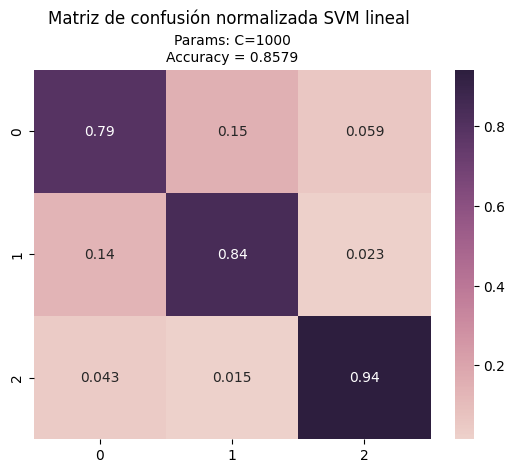

In [ ]:
accu_score = accuracy_score(y_val, y_pred)
plt.title(f'Params: C={best_model.C}\nAccuracy = {accu_score:.4f}', fontsize = 10)
sns.heatmap(np.round(confusion_matrix(y_val, y_pred, normalize='true'), decimals=4), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.suptitle('Matriz de confusión normalizada SVM lineal', x=0.43, y=1.005)
# for text in disp_norm.text_.ravel():
#     text.set_fontsize(14) # Ajusta fontsize
plt.savefig('conf_mat_svm.svg')

plt.show()

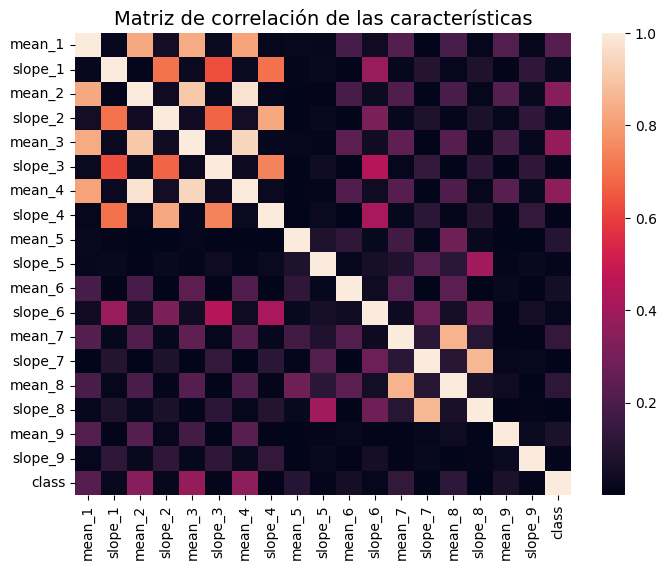

In [ ]:
plt.figure(figsize=(8,6))
correlation_data = df_train_w_class[df_train_w_class['class']==3].corr(method='pearson')
correlation_data_abs_value = abs(df_train_w_class[df_train_w_class['class']==3].corr(method='pearson'))

correlation_data = df_train_w_class.corr(method='pearson')
correlation_data_abs_value = abs(df_train_w_class.corr(method='pearson'))
sns.heatmap(correlation_data_abs_value)
plt.title("Matriz de correlación de las características", fontsize=14)
plt.savefig('corr_lineal.svg', format='svg', bbox_inches='tight', pad_inches=0)

Se concluye que la pendiente no tiene una importancia comparable a la de la media en la clasificación de las señales, pero debo sacar el gráfico anterior (matriz de correlación con la clase con las cracterísticas, que sería la media de cada señal) para realmente poder comparar como corresponde y decir porque la pendiente no sirve para clasificar las señales

## Segunda iteración de predicción del conjunto de test

In [ ]:
def test_pred_function(df_te, model):
  y_test_pred = model.predict(df_te)
  with open('pred_test_JE.csv', 'w') as f:
    f.write('Id,Category\n')
    for i in range(len(df_te)):
      f.write(f'{df_te.index[i]},{y_test_pred[i]}\n')

test_pred_function(df_test, best_model)

# III) Cascada de clasificadores
Se clasifica la clase 3 y luego se clasifican las 1 y 2 por separado, del punto anterior se concluyó, con respecto al vecotr de carcaterísticas, que la mejor característica para clasificar la data resultó ser la media, yq eu otras características como la varianza, skew o sma solo mantienen el accuracy o incluso lo disminuyen como sucedió con la varianza, en el primer vector de características se vió que esta carcatrística solo emperoraba el rendimiento general, ya que al quitarla y además aumentar el C, el clasificador pasó de tener un accuracy de validación de 86% a 92%.

In [ ]:
def calculation_feature_vector_2(df_data):

  caracs_list = []

  big_data_arr = np.zeros((len(df_data), 9))

  for i in range(0, len(df_data)):
  # for i in range(0, 2):
    data_list = []

    for j in range(1,10):

      if j == 9:
        df_calc = df_data.loc[i, f'Humidity_0':f'Humidity_127'] #display(df_trainval.loc[i, f'Humidity_0':f'Humidity_127'])
      else:
        df_calc = df_data.loc[i, f'R{j}_0':f'R{j}_127'] #display(df_trainval.loc[i, f'R{j}_0':f'R{j}_127'])

      if i == 0:
        # 2° it features
        caracs_list.append('mean_' + str(j))
        # caracs_list.append('var_' + str(j))
        # caracs_list.append('min_' + str(j))
        # caracs_list.append('max_' + str(j))
        # caracs_list.append('sma_' + str(j))

        df = pd.DataFrame(columns=caracs_list)

      data_list.append(np.mean(df_calc))
      # data_list.append(np.var(df_calc))
      # data_list.append(min(df_calc))
      # data_list.append(max(df_calc))
      # data_list.append(np.ma.average(df_calc))
    # print(i)
    big_data_arr[i,:] = np.array(data_list)

  df = pd.DataFrame(big_data_arr, columns=caracs_list)

  if 'class' in df_data.columns:
    df = pd.concat([df, df_data['class']], axis=1)

  return df

In [ ]:
train_val_data_III = calculation_feature_vector_2(df_trainval)
df_test = calculation_feature_vector_2(df_test_no_labels)

In [ ]:
df_train, df_val = train_test_split(train_val_data_III, test_size=0.3, random_state=10, stratify=train_val_data_II['class'])

scaler = StandardScaler().fit(df_train.iloc[:,0:9])

df_train.iloc[:,0:9] = scaler.transform(df_train.iloc[:,0:9])
df_val.iloc[:,0:9] = scaler.transform(df_val.iloc[:,0:9])
df_test.iloc[:,0:9] = scaler.transform(df_test.iloc[:,0:9])

df_train_w_class = df_train.copy()
df_val_w_class = df_val.copy()

y_train = df_train.pop('class')# - 1
y_val = df_val.pop('class')# - 1

In [ ]:
# 1° iteración:
# parameters = {'C':[0.01, 0.1, 1, 10, 100]}
# svc = svm.SVC(kernel='linear')

# 2° iteración:
# parameters = {'C':[0.1, 1, 10], 'degree':[2,3,4]}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

# 3° iteración:
parameters = {'C':[200, 500, 1000, 5000], 'degree':[2,3,4]}
svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

clf = GridSearchCV(svc, parameters, cv=ps)

# GridSearch
t0 = time.time()
clf.fit(df_val, y_val)
t = time.time()
tiempo_svm_lin_grid_search = t - t0
print('Tiempo GridSearch SVM lineal: ',tiempo_svm_lin_grid_search)

display(pd.DataFrame(clf.cv_results_)) # Resultados del GridSearchCV()

best_model = clf.best_estimator_ # Se extraen los mejores hiperparámetros calculados a través de GridSearchCV()
# svc_lin = svm.SVC(kernel='linear', C=best_model.C)# Se define un nuevo SVM con los mejores hiperparámetros

# Entrenamiento del SVM lineal con el conjunto de entrenamiento
t0 = time.time()
best_model.fit(df_train, y_train)
t = time.time()
tiempo_svm_lin_training = t - t0
print('Tiempo entrenamiento SVM lineal: ',tiempo_svm_lin_training)

print('Tiempo GridSearch + Entrenamiento =',tiempo_svm_lin_grid_search+tiempo_svm_lin_training)
y_pred = best_model.predict(df_val) # Predicción del conjunto de validación

Tiempo GridSearch SVM lineal:  44.57971954345703


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.371135,0.0,0.060842,0.0,200,2,"{'C': 200, 'degree': 2}",0.661616,0.661616,0.0,12
1,0.562824,0.0,0.056952,0.0,200,3,"{'C': 200, 'degree': 3}",0.691919,0.691919,0.0,9
2,0.904423,0.0,0.056370,0.0,200,4,"{'C': 200, 'degree': 4}",0.718434,0.718434,0.0,5
3,0.517559,0.0,0.059153,0.0,500,2,"{'C': 500, 'degree': 2}",0.680556,0.680556,0.0,11
4,0.912879,0.0,0.056014,0.0,500,3,"{'C': 500, 'degree': 3}",0.709596,0.709596,0.0,8
5,1.604682,0.0,0.051868,0.0,500,4,"{'C': 500, 'degree': 4}",0.744949,0.744949,0.0,4
6,0.741986,0.0,0.057042,0.0,1000,2,"{'C': 1000, 'degree': 2}",0.688131,0.688131,0.0,10
7,2.160672,0.0,0.086544,0.0,1000,3,"{'C': 1000, 'degree': 3}",0.718434,0.718434,0.0,5
8,2.941602,0.0,0.050041,0.0,1000,4,"{'C': 1000, 'degree': 4}",0.766414,0.766414,0.0,3
9,2.002565,0.0,0.053482,0.0,5000,2,"{'C': 5000, 'degree': 2}",0.717172,0.717172,0.0,7


Tiempo entrenamiento SVM lineal:  75.33300042152405
Tiempo GridSearch + Entrenamiento = 119.91271996498108


In [ ]:
# Separación de los datasets
df_val_1_2 = df_val[y_val != 3]         #Estos son los datos que voy a usar para validar el segundo clasificador
df_train_1_2 = df_train[y_train != 3]

y_train_1_2 = y_train[y_train != 3]  #Estas son las clases de los datos que voy a usar para validar el segundo clasificador
y_val_1_2 = y_val[y_val != 3]

df_val_pred_1_2 = df_val[y_pred != 3]    #Estos son los datos que voy a reclasificar, los que fueron predichos como 1 o 2
y_pred_1_2 = y_pred[y_pred != 3]         #Estas son las clases de los datos que voy a reclasificar

# len(df_val_1_2)
# len(y_val_class_1_2)
# len(y_pred_class_1_2) # La dimensión de este array es menor que el conjunto de validación debido a que no contiene todas las observaciónes predichas que realmente tienen las clases 1 o 2. Faltan aquellas que fueron predichas como 3 y que en realidad son de la clase 1 o 2
# len(df_val_pred_class_1_2)
# len(df_val[y_pred == 3])

# print(len(df_val_pred_class_1_2)+len(df_val[y_pred == 3]))
# print(len(df_val))

Permutación predefinida para la validación del modelo

In [ ]:
n_samples = len(y_val_1_2)                                        # Longitud del set de datos de validación, este dato se usará para definir que elementos se usarán para entrenamiento y validación en GridSearchCV()
n_train_grid_search = int(n_samples * 0.7)                    # 80% de los datos utilizdos para entrenamiento
n_val_grid_search = n_samples - n_train_grid_search           # El 20% restante para validación

np.random.seed(42)
indices = np.random.permutation(n_samples)                    # Tomar índices de forma aleatoria
test_fold = np.full(n_samples, -1)                        # Se define el arreglo de los índices de elemntos de train y test

# Asignar 1 a los índices que serán test
test_indices = indices[:n_val_grid_search]
test_fold[test_indices] = 1

ps = PredefinedSplit(test_fold)

In [ ]:
display(df_val_pred_1_2)

,mean_R1,mean_R2,mean_R3,mean_R4,mean_R5,mean_R6,mean_R7,mean_R8,mean_Humidity
239,1.096543,0.748626,0.703782,0.742589,-0.153586,-0.538695,0.610996,0.603499,-0.133996
7493,-2.436857,-0.862523,-0.915979,-0.824571,-0.319958,0.928797,-0.686096,-0.684933,-0.857180
6571,0.818759,0.429849,0.442854,0.426695,-0.068313,-1.100757,-0.005982,-0.022726,-0.140114
6549,0.634276,0.715461,0.701750,0.710410,-0.075733,-1.048698,-0.016646,-0.036925,0.672947
6343,1.105231,0.964985,0.942559,0.964935,-0.021235,-0.951169,0.033498,0.020603,-1.747880
...,...,...,...,...,...,...,...,...,...
2530,0.295776,-0.011892,-0.423304,0.187367,-0.223617,0.775180,-0.068628,0.266574,0.097315
943,-0.031109,-0.153198,-1.431315,-0.095407,-0.453486,-1.775178,-0.891543,-0.767952,0.599935
5597,-5.223277,-2.959463,-3.278409,-3.124802,-0.594448,-2.977505,-0.939698,-0.956904,-0.664565
2263,-1.541668,-0.103461,-1.692822,-0.278799,-0.288122,-1.451974,-0.500043,-0.384711,-0.244440


Segundo clasificador

In [ ]:
# 3° iteración: (Del mismo clasificador que estaba usando antes)
# parameters = {'C':[200, 500, 1000, 5000], 'degree':[2,3,4]}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

# 4° iteración: (Para mejorar la clasificación entre 1 y 2, se penaliza mucho más el error en la clase 1, ya que es la clase que da el accuracy más bajo)
# parameters = {'C':[200, 500, 1000, 5000], 'degree':[2,3,4]}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale', class_weight={1: 2, 2: 1})

# 4° a) iteración:
# parameters = {'C':[200, 500, 1000, 5000], 'degree':[2,3,4], 'class_weight': [
#         {1: 1, 2: 1},     # Sin penalización
#         {1: 1, 2: 3},     # Penaliza más errores en clase 2
#         {1: 3, 2: 1},     # Penaliza más errores en clase 1
#         'balanced'        # Automático según la distribución de clases
#     ]}

# 4° b) iteración: 10/07
parameters = {'C':[1, 10, 100], 'kernel':['rbf'], 'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10], 'class_weight': [
        {1: 1, 2: 1},     # Sin penalización
        {1: 1, 2: 3},     # Penaliza más errores en clase 2
        {1: 3, 2: 1},     # Penaliza más errores en clase 1
        'balanced'        # Automático según la distribución de clases
    ]}

# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')
svc = svm.SVC()

clf = GridSearchCV(svc, parameters, cv=ps)

# GridSearch
t0 = time.time()
clf.fit(df_val_1_2, y_val_1_2)
t = time.time()
tiempo_svm_lin_grid_search = t - t0
print('Tiempo GridSearch SVM lineal: ',tiempo_svm_lin_grid_search)

display(pd.DataFrame(clf.cv_results_)) # Resultados del GridSearchCV()

best_model_2 = clf.best_estimator_ # Se extraen los mejores hiperparámetros calculados a través de GridSearchCV()
# svc_lin = svm.SVC(kernel='linear', C=best_model.C)# Se define un nuevo SVM con los mejores hiperparámetros

# Entrenamiento del SVM lineal con el conjunto de entrenamiento
t0 = time.time()
best_model_2.fit(df_train_1_2, y_train_1_2)
t = time.time()
tiempo_svm_lin_training = t - t0
print('Tiempo entrenamiento SVM lineal: ',tiempo_svm_lin_training)

print('Tiempo GridSearch + Entrenamiento =',tiempo_svm_lin_grid_search+tiempo_svm_lin_training)
y_pred_1_2 = best_model_2.predict(df_val_pred_1_2) # Predicción del conjunto de validación

Tiempo GridSearch SVM lineal:  4.674489498138428


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_gamma,param_kernel,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.104946,0.0,0.065760,0.0,1,"{1: 1, 2: 1}",0.001268,rbf,"{'C': 1, 'class_weight': {1: 1, 2: 1}, 'gamma'...",0.615530,0.615530,0.0,35
1,0.097726,0.0,0.060798,0.0,1,"{1: 1, 2: 1}",0.012684,rbf,"{'C': 1, 'class_weight': {1: 1, 2: 1}, 'gamma'...",0.649621,0.649621,0.0,34
2,0.088228,0.0,0.054423,0.0,1,"{1: 1, 2: 1}",0.126839,rbf,"{'C': 1, 'class_weight': {1: 1, 2: 1}, 'gamma'...",0.734848,0.734848,0.0,19
3,0.076679,0.0,0.041393,0.0,1,"{1: 1, 2: 1}",1.268386,rbf,"{'C': 1, 'class_weight': {1: 1, 2: 1}, 'gamma'...",0.869318,0.869318,0.0,10
4,0.062845,0.0,0.025764,0.0,1,"{1: 1, 2: 3}",0.001268,rbf,"{'C': 1, 'class_weight': {1: 1, 2: 3}, 'gamma'...",0.511364,0.511364,0.0,44
5,0.056964,0.0,0.026925,0.0,1,"{1: 1, 2: 3}",0.012684,rbf,"{'C': 1, 'class_weight': {1: 1, 2: 3}, 'gamma'...",0.535985,0.535985,0.0,41
6,0.054104,0.0,0.023991,0.0,1,"{1: 1, 2: 3}",0.126839,rbf,"{'C': 1, 'class_weight': {1: 1, 2: 3}, 'gamma'...",0.653409,0.653409,0.0,33
7,0.050900,0.0,0.026216,0.0,1,"{1: 1, 2: 3}",1.268386,rbf,"{'C': 1, 'class_weight': {1: 1, 2: 3}, 'gamma'...",0.888258,0.888258,0.0,9
8,0.052837,0.0,0.026384,0.0,1,"{1: 3, 2: 1}",0.001268,rbf,"{'C': 1, 'class_weight': {1: 3, 2: 1}, 'gamma'...",0.490530,0.490530,0.0,48
9,0.053609,0.0,0.025751,0.0,1,"{1: 3, 2: 1}",0.012684,rbf,"{'C': 1, 'class_weight': {1: 3, 2: 1}, 'gamma'...",0.492424,0.492424,0.0,45


Tiempo entrenamiento SVM lineal:  0.47613072395324707
Tiempo GridSearch + Entrenamiento = 5.150620222091675


In [ ]:
y_pred_1_2 = best_model_2.predict(df_val_pred_1_2) # Predicción del conjunto de validación

In [ ]:
# Paso 1: máscara de elementos clasificados como 1 o 2 por el primer modelo
mask_1_2 = y_pred != 3  # boolean array del mismo largo que y_pred

# Paso 2: inicializa un array con las predicciones del primer modelo
# (esto evitará errores de tamaño o indexación)
y_pred_final = y_pred.copy()

# Paso 3: reemplaza las posiciones de clase 1 o 2 por la nueva predicción del segundo modelo
y_pred_final[mask_1_2] = y_pred_1_2

In [ ]:
y_pred_final

array([1., 3., 2., ..., 2., 2., 3.])

              precision    recall  f1-score   support

         1.0       0.95      0.90      0.92       879
         2.0       0.95      0.96      0.95       880
         3.0       0.95      0.99      0.97       880

    accuracy                           0.95      2639
   macro avg       0.95      0.95      0.95      2639
weighted avg       0.95      0.95      0.95      2639



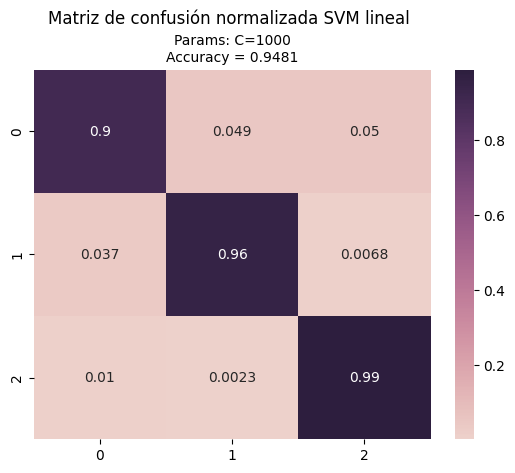

In [ ]:
# y_class_1_2 = y_val[y_val != 3]
print(classification_report(y_val, y_pred_final))

accu_score = accuracy_score(y_val, y_pred_final)
plt.title(f'Params: C={best_model.C}\nAccuracy = {accu_score:.4f}', fontsize = 10)
sns.heatmap(np.round(confusion_matrix(y_val, y_pred_final, normalize='true'), 4), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.suptitle('Matriz de confusión normalizada SVM lineal', x=0.43, y=1.005)


plt.show()

Se concluye que la clasificación en cascada no mejoró la clasificación global, de manera que se vuelve a este punto inicial, penalizando mucho más el error en la clase 1 para mejorar la clasificación entre 1 y 2

Se calcula la tercera predicción del conjunto de test, esta vez con el clasificador en cascada

In [ ]:
y_test_pred = best_model.predict(df_test)

In [ ]:
print(best_model.classes_)
best_model_2.classes_
print("Shape de clases:", best_model.classes_.shape)

[1. 2. 3.]
Shape de clases: (3,)


In [ ]:
y_pred_1_2 = best_model_2.predict(df_test) # Predicción del conjunto de validación

y_test_pred_1_2 = y_test_pred[y_test_pred != 3]

# Paso 1: máscara de elementos clasificados como 1 o 2 por el primer modelo
mask_1_2 = y_test_pred != 3  # boolean array del mismo largo que y_pred

# Paso 2: inicializa un array con las predicciones del primer modelo
# (esto evitará errores de tamaño o indexación)
y_test_pred_final = y_test_pred.copy()

# Paso 3: reemplaza las posiciones de clase 1 o 2 por la nueva predicción del segundo modelo
y_test_pred_final[mask_1_2] = y_test_pred_1_2

with open('pred_test.csv', 'w') as f:
  f.write('Id,Category\n')
  for i in range(len(df_test)):
    f.write(f'{df_test.index[i]},{int(y_test_pred_final[i])}\n')

# test_pred_function(df_test, best_model)

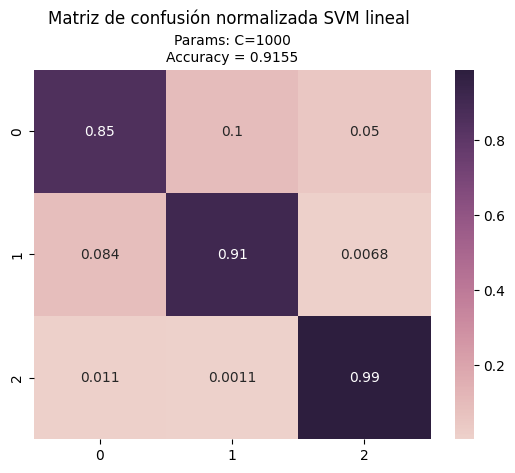

In [ ]:
accu_score = accuracy_score(y_val, y_pred)
plt.title(f'Params: C={best_model.C}\nAccuracy = {accu_score:.4f}', fontsize = 10)
sns.heatmap(np.round(confusion_matrix(y_val, y_pred, normalize='true'), 4), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.suptitle('Matriz de confusión normalizada SVM lineal', x=0.43, y=1.005)
# for text in disp_norm.text_.ravel():
#     text.set_fontsize(14) # Ajusta fontsize
plt.savefig('conf_mat_svm.svg')

plt.show()

In [ ]:
print("Clases en y_val:", np.unique(y_val))
print("Clases en y_pred:", np.unique(y_pred))

Clases en y_val: [1 2 3]
Clases en y_pred: [1 2 3]


# Borrador

#### Borrador de las celdas para conseguir el mejor SVM

In [ ]:
ps = predefined_split(y_val)

# 1° iteración:
# parameters = {'C':[0.01, 0.1, 1, 10, 100]}
# svc = svm.SVC(kernel='linear') #decision_function_shape{‘ovo’, ‘ovr’}, default=’ovr’

# 2° iteración:
# parameters = {'C':[0.1, 1, 10], 'degree':[2,3,4]}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

# 2° a) iteración:
# parameters = {'C':[0.1, 1, 10, 100, 200], 'degree':[2,3,4]}
# parameters = {'C':[0.1, 1, 10, 100, 1000], 'degree':[2,3,4],'kernel':['poly']}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

# 2° a) iteración:
# parameters = {'C':[100, 200, 500, 1000], 'degree':[2,3,4]}
# parameters = {'C':[100, 200, 500, 1000], 'degree':[2,3,4], 'kernel':['poly']}
# parameters = {'C':[200, 500, 1000, 5000], 'degree':[2,3,4], 'coef0':[-5, -1, 1, 5]}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')
parameters = {'C':[200, 500, 1000, 2000], 'degree':[2,3,4,5]}
svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')
# parameters = {'C':[200, 500, 1000, 2000], 'degree':[2,3,4],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
# svc = svm.SVC(kernel='poly', coef0=1)

# svc = svm.SVC(kernel='poly', gamma='scale')
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

# 3° iteración:
# parameters = {'C':[0.01, 0.1, 1, 10, 100], 'degree':[2,3,4], 'coef0':[-1, 1]}
# parameters = {'C':[0.01, 0.1, 1, 10, 100], 'kernel':['poly'], 'degree':[2,3,4], 'coef0':[-1, 1]} #Probado el 10/07, debo definir el kernel dentro de los parámetros
# svc = svm.SVC(kernel='poly', gamma='scale')
# Poco viable por el timepo de entrenamiento que toma

# 4° iteración:
# parameters = {'kernel':['rbf'],'C':[0.01, 0.1, 1, 10, 100],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
# parameters = {'kernel':['rbf'],'C':[1, 10, 100, 1000, 2000],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
# svc = svm.SVC(kernel='rbf')

# 5° iteración: (09/07) Selección del kernel mediante el GridSearch
# parameters = {'C':[0.01, 0.1, 1, 10, 100], 'kernel':['poly', 'rbf']} #Al tener como resultado el mayor C, se plantea un nuevo conjunto de valores C para el GridSearch
# parameters = {'C':[100, 200, 500, 1000, 2000],'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
# parameters = {'C':[0.01, 0.1, 1, 10, 100],'kernel':['linear', 'poly', 'rbf', 'sigmoid']}  #--------> Para probar el mejor kernel
# parameters = {'C':[0.01, 0.1, 1, 10, 100],'kernel':['linear', 'poly', 'rbf', 'sigmoid']} #Al tener como resultado el mayor C, se plantea un nuevo conjunto de valores C para el GridSearch
# parameters = {'C':[0.1, 1, 10, 100], 'kernel':['rbf'], 'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
# parameters = {'C':[1, 10, 100, 200], 'kernel':['rbf'], 'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10]} #Probado el 10/07
# parameters = {'C':[1, 10, 100], 'kernel':['rbf'], 'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10]} # Pruebo este vector el 10/07 para verificar el clasificador con el nuevo vector de características y de esta forma evaluar el tiempo de cálculo y el nuevo vector
# parameters = {'C':[0.01, 0.1, 1, 10, 100],'kernel':['sigmoid','poly', 'rbf']} #Al tener como resultado el mayor C, se plantea un nuevo conjunto de valores C para el GridSearch

best_model = make_clf(svc, parameters, df_train, y_train, df_val, y_val)
# best_model = make_clf(parameters, df_train.iloc[:,0:44], y_train, df_val.iloc[:,0:44], y_val)

y_pred = best_model.predict(df_val) # Predicción del conjunto de validación
# y_pred = best_model.predict(df_val.iloc[:,0:44]) # Predicción del conjunto de validación

Tiempo GridSearch SVM lineal:  129.43655729293823


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,1.059953,0.0,0.025252,0.0,200,2,"{'C': 200, 'degree': 2}",0.785354,0.785354,0.0,15
1,1.968902,0.0,0.026243,0.0,200,3,"{'C': 200, 'degree': 3}",0.835859,0.835859,0.0,11
2,2.271038,0.0,0.017093,0.0,200,4,"{'C': 200, 'degree': 4}",0.854798,0.854798,0.0,8
3,3.453155,0.0,0.025424,0.0,200,5,"{'C': 200, 'degree': 5}",0.891414,0.891414,0.0,3
4,2.511131,0.0,0.023767,0.0,500,2,"{'C': 500, 'degree': 2}",0.796717,0.796717,0.0,13
5,6.270993,0.0,0.026727,0.0,500,3,"{'C': 500, 'degree': 3}",0.833333,0.833333,0.0,12
6,4.300199,0.0,0.026990,0.0,500,4,"{'C': 500, 'degree': 4}",0.866162,0.866162,0.0,7
7,3.811153,0.0,0.015512,0.0,500,5,"{'C': 500, 'degree': 5}",0.883838,0.883838,0.0,5
8,5.232903,0.0,0.023627,0.0,1000,2,"{'C': 1000, 'degree': 2}",0.789141,0.789141,0.0,14
9,19.762902,0.0,0.019646,0.0,1000,3,"{'C': 1000, 'degree': 3}",0.849747,0.849747,0.0,9


Tiempo entrenamiento SVM lineal:  33.46855592727661
Tiempo GridSearch + Entrenamiento = 162.90511322021484


In [ ]:
def calculation_feature_vector(df_data):

  caracs_list = []

  big_data_arr = np.zeros((len(df_data), 18))

  for i in range(0, len(df_data)):
  # for i in range(0, 2):
    data_list = []

    for j in range(1,10):

      if j == 9:
        df_calc = df_data.loc[i, f'Humidity_0':f'Humidity_127'] #display(df_trainval.loc[i, f'Humidity_0':f'Humidity_127'])
      else:
        df_calc = df_data.loc[i, f'R{j}_0':f'R{j}_127'] #display(df_trainval.loc[i, f'R{j}_0':f'R{j}_127'])

      if i == 0:
        caracs_list.append('mean_' + str(j))
        caracs_list.append('var_' + str(j))
        caracs_list.append('mad_' + str(j)) # Desde aquí es el nuevo vector de carcaterísticas que debería haber probado desde un principio
        caracs_list.append('max_' + str(j))

        caracs_list.append('min_' + str(j))
        caracs_list.append('sma_' + str(j))
        caracs_list.append('enrgy_' + str(j))
        caracs_list.append('iqr_' + str(j))

        caracs_list.append('entpy_' + str(j))
        caracs_list.append('arCoeff_' + str(j))
        caracs_list.append('corr_' + str(j))

        df = pd.DataFrame(columns=caracs_list)

      data_list.append(np.mean(df_calc))
      data_list.append(np.var(df_calc))
      data_list.append(np.median(np.abs(df_calc - np.median(df_calc))))
      data_list.append(np.max(df_calc))

      data_list.append(np.min(df_calc))
      data_list.append(np.sum(np.abs(df_calc)))
      data_list.append(np.sum(df_calc**2)/len(df_calc))
      data_list.append(sp.stats.iqr(df_calc))

      data_list.append(sp.stats.entropy(df_calc))
      data_list.append(arr_coef) # No sé como implementar esto en python pero puedes dejarlo en este formato para cuando descubra la librería que permite calcular esta característica
      data_list.append(np.corrcoef(df_calc[:-1], df_calc[1:])[0][1])


    big_data_arr[i,:] = np.array(data_list)

  df = pd.DataFrame(big_data_arr, columns=caracs_list)

  if 'class' in df_data.columns:
    df = pd.concat([df, df_data['class']], axis=1)

  return df

Se organizan los datos en un array de la forma i,j,k, se hace esto para facilitar la programación del cálculo de características

In [ ]:
array_train_val = np.zeros((len(df_trainval), 9, 128)) # Matriz -> n° de muestras X n° de sensores X tamaño de la ventana  ->  [8795, 8, 127]

k = array_train_val.shape[-1]

for i in range(array_train_val.shape[0]):

  for j in range(array_train_val.shape[1]):

    array_train_val[i,j,:] = np.array(df_trainval.loc[i][j*k : k + j*k])

In [ ]:
print(array_train_val[0,0,:].shape)
np.array(df_trainval.loc[0][2*128 : 128 + 2*128]).shape

(128,)


(128,)

In [ ]:
train_val_caracs = pd.DataFrame()
# np.zeros((len(df_trainval), 18)) # Matriz -> n° de muestras X n° de sensores X tamaño de la ventana  ->  [8795, 8, 127]

column_names_caracs = []

for i in range(array_train_val.shape[0]):
  means = []
  variances = []

  print(i)

  for j in range(array_train_val.shape[1]):

    means.append(np.mean(array_train_val[i,j,:]))
    variances.append(np.var(array_train_val[i,j,:]))

    if i == 0:
      column_names_caracs.append('mean_' + str(j+1))
      column_names_caracs.append('vars_' + str(j+1))

  display(pd.DataFrame(means).concat(pd.DataFrame(variances)))


  # train_val_caracs = train_val_caracs.append(pd.Series(means + variances), ignore_index=True)

# train_val_caracs

NameError: name 'array_train_val' is not defined

In [ ]:
df_trainval_caracs = pd.DataFrame(array_train_caracs, columns=column_names_caracs)
df_trainval_caracs
# array_train_val[0,0,:]

,mean_1,mean_2,mean_3,mean_4,mean_5,mean_6,mean_7,mean_8,mean_9
0,12.754292,10.025339,10.148645,11.289939,11.385055,18.354793,4.825439,5.305171,60.131052
1,11.967599,8.068474,8.285822,7.607900,11.844489,16.910116,2.535805,3.026097,65.021354
2,10.874177,6.733694,4.255943,8.015534,14.331759,14.787651,1.883080,2.149658,56.372610
3,12.554823,9.927928,10.074674,11.206576,10.498980,16.661062,7.049197,7.333878,64.552841
4,8.396118,5.376859,3.503016,6.654920,5.419658,14.696602,2.338161,2.889587,58.124579
...,...,...,...,...,...,...,...,...,...
8791,12.412083,9.383410,9.548767,10.667314,10.898194,18.001598,5.556913,6.264065,50.446031
8792,12.834633,9.708894,9.818239,10.988033,19.437108,17.201457,6.097525,6.517089,53.291634
8793,11.981392,9.590782,9.755056,11.072576,10.708553,16.235656,6.379035,7.499586,67.555945
8794,12.913830,10.145803,10.285827,11.450341,11.323898,17.286553,6.387599,6.876442,52.303113


In [ ]:
caracs_list = []

big_data_arr = np.zeros((len(df_trainval), 18))

for i in range(0, len(df_trainval)):
  data_list = []

  for j in range(1,10):

    if j == 9:
      df_calc = df_trainval.loc[i, f'Humidity_0':f'Humidity_127'] #display(df_trainval.loc[i, f'Humidity_0':f'Humidity_127'])
    else:
      df_calc = df_trainval.loc[i, f'R{j}_0':f'R{j}_127'] #display(df_trainval.loc[i, f'R{j}_0':f'R{j}_127'])

    if i == 0:
      caracs_list.append('mean_' + str(j))
      caracs_list.append('var_' + str(j))

      df_train_val = pd.DataFrame(columns=caracs_list)

    data_list.append(np.mean(df_calc))
    data_list.append(np.var(df_calc))

  big_data_arr[i,:] = np.array(data_list)

df_train_val = pd.DataFrame(big_data_arr, columns=caracs_list)
df_train_val = pd.concat([df_train_val, df_trainval['class']], axis=1)
df_train_val
# display(array_train_caracs)
# print(big_data_arr)

,mean_1,var_1,mean_2,var_2,mean_3,var_3,mean_4,var_4,mean_5,var_5,mean_6,var_6,mean_7,var_7,mean_8,var_8,mean_9,var_9,class
0,12.754292,1.906951e-04,10.025339,2.522271e-03,10.148645,1.373784e-03,11.289939,0.002741,11.385055,3.019404e-03,18.354793,0.000251,4.825439,1.891078e-04,5.305171,2.026727e-04,60.131052,0.004940,1
1,11.967599,4.615858e-02,8.068474,1.747379e-01,8.285822,1.192520e-01,7.607900,0.037851,11.844489,6.111635e-04,16.910116,0.052403,2.535805,7.630309e-03,3.026097,3.469361e-02,65.021354,0.012975,1
2,10.874177,1.686482e-04,6.733694,8.399944e-03,4.255943,7.255871e-02,8.015534,0.014101,14.331759,4.511163e-05,14.787651,0.020747,1.883080,1.527344e-03,2.149658,1.502168e-03,56.372610,0.005181,1
3,12.554823,9.594409e-06,9.927928,1.547504e-06,10.074674,5.384760e-07,11.206576,0.000003,10.498980,5.700092e-07,16.661062,0.000034,7.049197,1.462127e-07,7.333878,5.272732e-08,64.552841,0.000700,1
4,8.396118,1.375398e-01,5.376859,1.803704e-01,3.503016,2.255354e-01,6.654920,0.032712,5.419658,3.459920e-02,14.696602,1.606592,2.338161,7.527932e-03,2.889587,8.011927e-03,58.124579,0.052991,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8791,12.412083,2.465645e-04,9.383410,1.878341e-04,9.548767,3.238135e-04,10.667314,0.000181,10.898194,7.399777e-05,18.001598,0.000071,5.556913,3.080433e-05,6.264065,1.567876e-05,50.446031,0.129468,3
8792,12.834633,4.851733e-07,9.708894,6.730447e-07,9.818239,2.962567e-06,10.988033,0.000012,19.437108,3.249446e-04,17.201457,0.000003,6.097525,4.279667e-06,6.517089,1.666033e-06,53.291634,0.000174,3
8793,11.981392,1.075543e-04,9.590782,4.493687e-05,9.755056,3.997650e-05,11.072576,0.000064,10.708553,3.387687e-05,16.235656,0.000048,6.379035,6.832402e-06,7.499586,5.392002e-05,67.555945,0.029843,3
8794,12.913830,2.502985e-04,10.145803,5.793843e-05,10.285827,7.715424e-06,11.450341,0.000036,11.323898,2.544722e-03,17.286553,0.001164,6.387599,3.191764e-05,6.876442,5.058336e-05,52.303113,0.003369,3
